In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FFNN_model
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time
import sys
import os

## Load dataset

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X data type: {X.dtype}")
print(f"y data type: {y.dtype}")

X shape: (70000, 784)
y shape: (70000,)
X data type: int64
y data type: object


convert string labels to int

In [3]:
y = y.astype(np.int64)
y.dtype

dtype('int64')

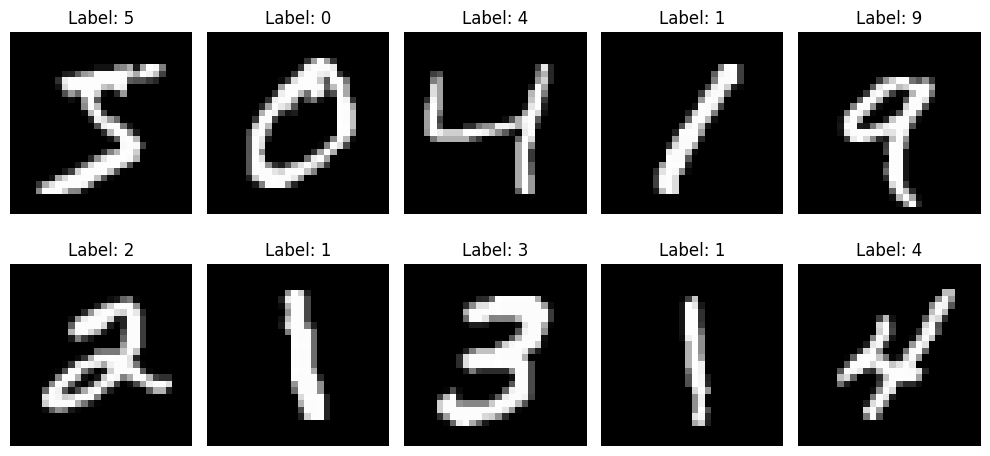

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocessing Data

In [5]:
X_scaled = X/255.0

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

# original labels for evaluation
_, _, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 56000
Test set size: 14000


smaller data train for faster experiment

In [6]:
X_train_small, _, y_train_onehot_small, _ = train_test_split(
    X_train, y_train_onehot, test_size=0.8, random_state=42
)

X_test_small, _, y_test_onehot_small, _ = train_test_split(
    X_test, y_test_onehot, test_size=0.8, random_state=42
)

print(f"Small training set size: {X_train_small.shape[0]}")
print(f"Small test set size: {X_test_small.shape[0]}")

Small training set size: 11200
Small test set size: 2800


## Visualization

In [7]:
def evaluate_model(model, X_test, y_test_onehot, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_onehot, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot some examples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        idx = np.random.randint(0, len(X_test))
        img = X_test[idx].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        true_label = np.argmax(y_test_onehot[idx])
        pred_label = np.argmax(y_pred_probs[idx])
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred

In [8]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Experiment 1 : Effect of Depth and Width

In [9]:
# Define the different architectures
architectures = [
    # Varying width (fixed depth)
    {
        'name': 'Small width',
        'layers': [32, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Medium width',
        'layers': [64, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Large width',
        'layers': [128, 10],
        'activations': ['relu', 'softmax']
    },
    
    # Varying depth (fixed width)
    {
        'name': 'Shallow depth',
        'layers': [64, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Medium depth',
        'layers': [64, 32, 10],
        'activations': ['relu', 'relu', 'softmax']
    },
    {
        'name': 'Deep network',
        'layers': [128, 64, 32, 10],
        'activations': ['relu', 'relu', 'relu', 'softmax']
    }
]

params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with architecture: Small width
Layers: [32, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0889 - val_loss: 1.8780
Epoch 2/20 [10.0%] - train_loss: 1.7001 - val_loss: 1.5432
Epoch 3/20 [15.0%] - train_loss: 1.4063 - val_loss: 1.2859
Epoch 4/20 [20.0%] - train_loss: 1.1836 - val_loss: 1.0928
Epoch 5/20 [25.0%] - train_loss: 1.0187 - val_loss: 0.9521
Epoch 6/20 [30.0%] - train_loss: 0.9006 - val_loss: 0.8521
Epoch 7/20 [35.0%] - train_loss: 0.8152 - val_loss: 0.7785
Epoch 8/20 [40.0%] - train_loss: 0.7508 - val_loss: 0.7222
Epoch 9/20 [45.0%] - train_loss: 0.7006 - val_loss: 0.6773
Epoch 10/20 [50.0%] - train_loss: 0.6602 - val_loss: 0.6409
Epoch 11/20 [55.0%] - train_loss: 0.6270 - val_loss: 0.6107
Epoch 12/20 [60.0%] - train_loss: 0.5991 - val_loss: 0.5852
Epoch 13/20 [65.0%] - train_loss: 0.5753 - val_loss: 0.5633
Epoch 14/20 [70.0%] - train_loss: 0.5547 - val_loss: 0.5444
Epoch 15/20 [75.0%] - train_loss: 0.5368 - val_loss: 0.5276
Epoch 16/20 [

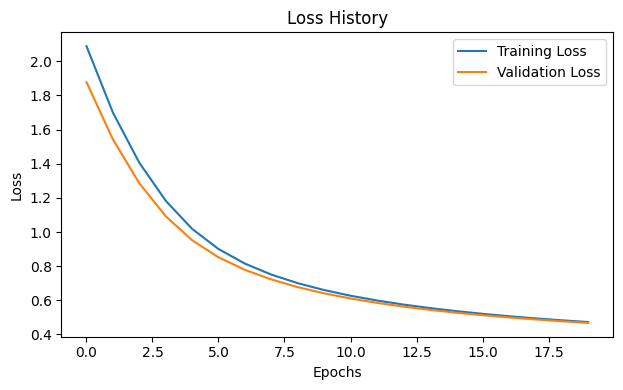


Evaluating model with Small width [32, 10] activation...
Accuracy: 0.8764
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1343
           1       0.90      0.97      0.93      1600
           2       0.88      0.84      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.87      0.87      1295
           5       0.85      0.80      0.83      1273
           6       0.89      0.91      0.90      1396
           7       0.90      0.89      0.90      1503
           8       0.84      0.80      0.82      1357
           9       0.83      0.87      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.88      0.88     14000



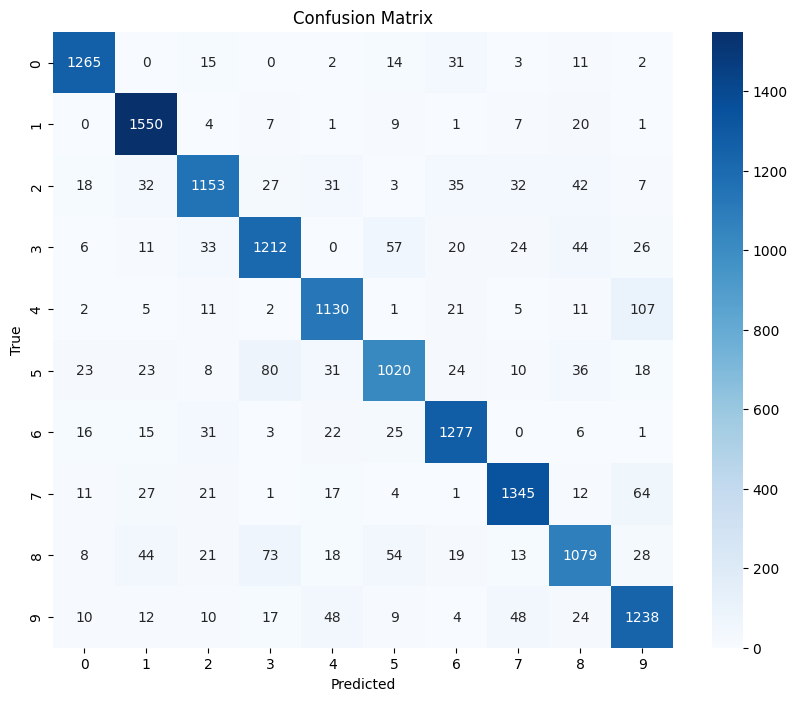

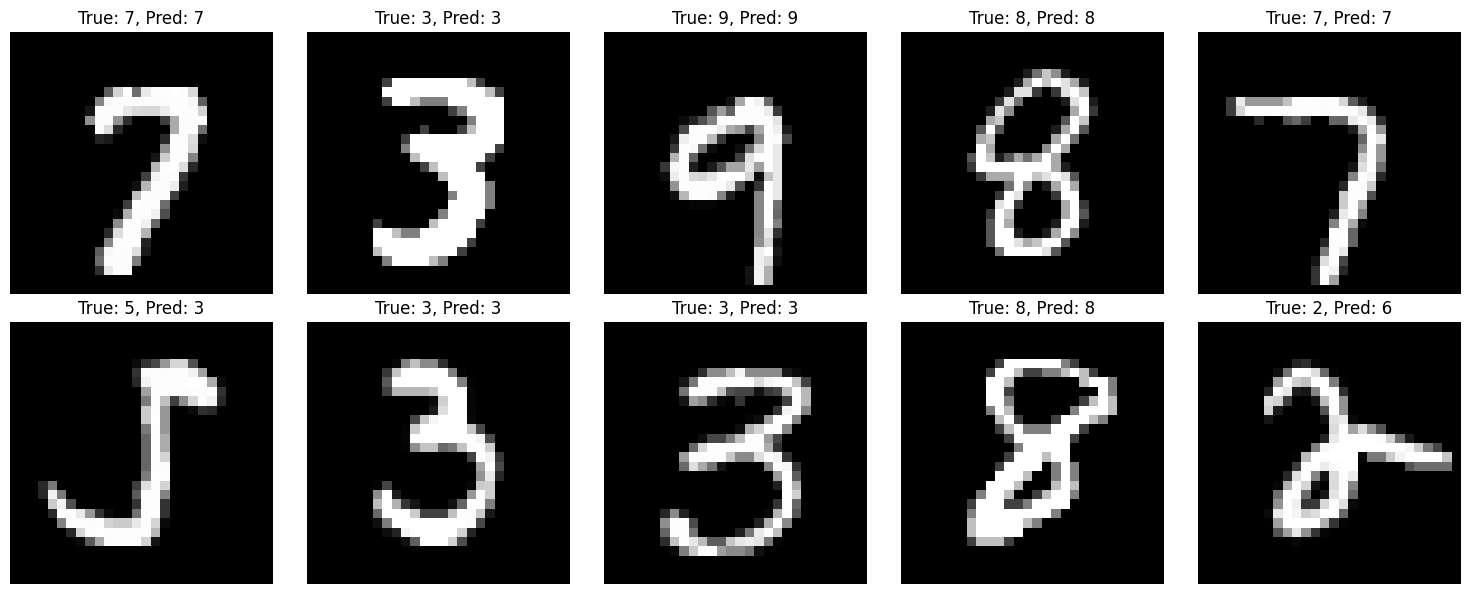


Training model with architecture: Medium width
Layers: [64, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1349 - val_loss: 1.9080
Epoch 2/20 [10.0%] - train_loss: 1.7146 - val_loss: 1.5387
Epoch 3/20 [15.0%] - train_loss: 1.3953 - val_loss: 1.2640
Epoch 4/20 [20.0%] - train_loss: 1.1634 - val_loss: 1.0690
Epoch 5/20 [25.0%] - train_loss: 0.9993 - val_loss: 0.9302
Epoch 6/20 [30.0%] - train_loss: 0.8817 - val_loss: 0.8296
Epoch 7/20 [35.0%] - train_loss: 0.7953 - val_loss: 0.7548
Epoch 8/20 [40.0%] - train_loss: 0.7300 - val_loss: 0.6976
Epoch 9/20 [45.0%] - train_loss: 0.6794 - val_loss: 0.6524
Epoch 10/20 [50.0%] - train_loss: 0.6389 - val_loss: 0.6160
Epoch 11/20 [55.0%] - train_loss: 0.6059 - val_loss: 0.5861
Epoch 12/20 [60.0%] - train_loss: 0.5785 - val_loss: 0.5610
Epoch 13/20 [65.0%] - train_loss: 0.5553 - val_loss: 0.5397
Epoch 14/20 [70.0%] - train_loss: 0.5354 - val_loss: 0.5214
Epoch 15/20 [75.0%] - train_loss: 0.5182 - val_loss: 0.5053
Epoch 16/20 

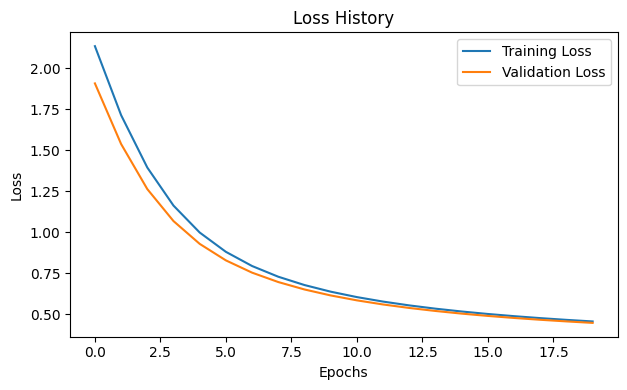


Evaluating model with Medium width [64, 10] activation...
Accuracy: 0.8825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.93      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.90      0.88      1295
           5       0.87      0.80      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.85      0.83      0.84      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



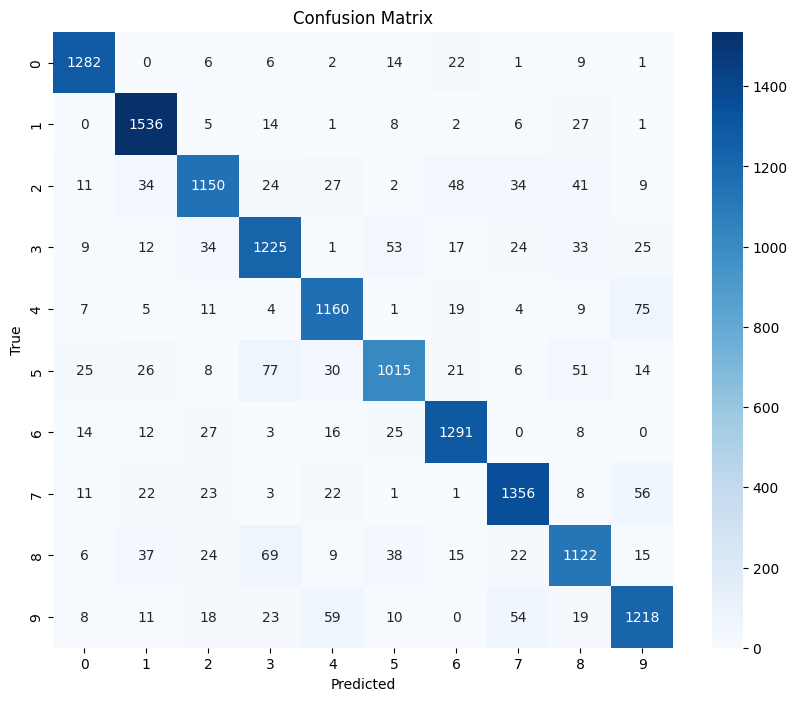

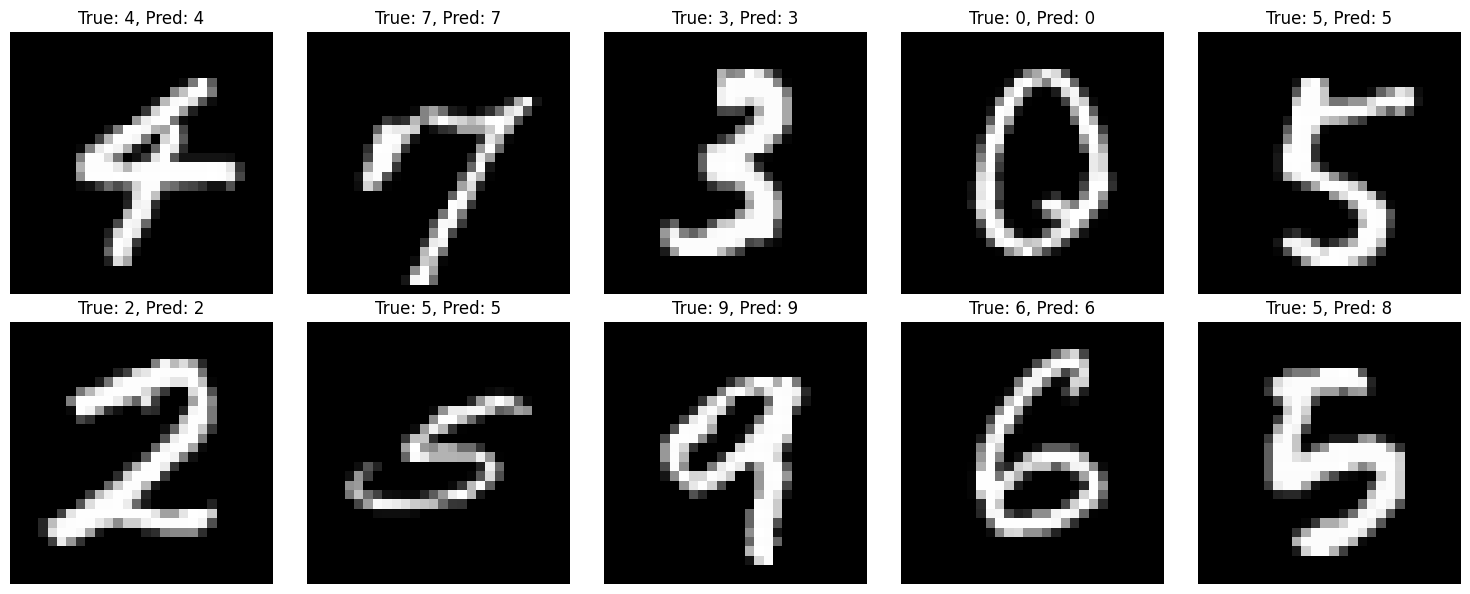


Training model with architecture: Large width
Layers: [128, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0910 - val_loss: 1.8662
Epoch 2/20 [10.0%] - train_loss: 1.6726 - val_loss: 1.4964
Epoch 3/20 [15.0%] - train_loss: 1.3512 - val_loss: 1.2228
Epoch 4/20 [20.0%] - train_loss: 1.1232 - val_loss: 1.0343
Epoch 5/20 [25.0%] - train_loss: 0.9661 - val_loss: 0.9033
Epoch 6/20 [30.0%] - train_loss: 0.8554 - val_loss: 0.8094
Epoch 7/20 [35.0%] - train_loss: 0.7745 - val_loss: 0.7395
Epoch 8/20 [40.0%] - train_loss: 0.7131 - val_loss: 0.6857
Epoch 9/20 [45.0%] - train_loss: 0.6650 - val_loss: 0.6430
Epoch 10/20 [50.0%] - train_loss: 0.6263 - val_loss: 0.6082
Epoch 11/20 [55.0%] - train_loss: 0.5946 - val_loss: 0.5795
Epoch 12/20 [60.0%] - train_loss: 0.5680 - val_loss: 0.5552
Epoch 13/20 [65.0%] - train_loss: 0.5454 - val_loss: 0.5346
Epoch 14/20 [70.0%] - train_loss: 0.5260 - val_loss: 0.5167
Epoch 15/20 [75.0%] - train_loss: 0.5091 - val_loss: 0.5010
Epoch 16/20 

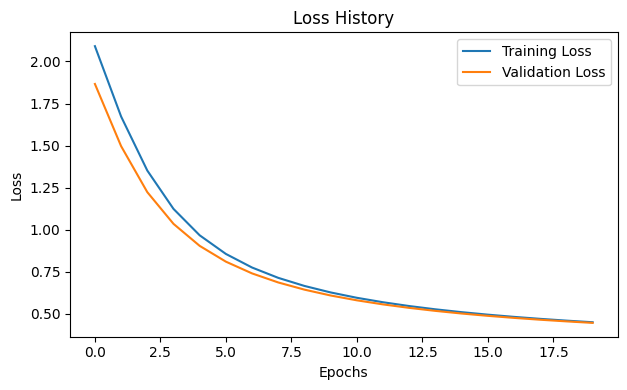


Evaluating model with Large width [128, 10] activation...
Accuracy: 0.8831
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.97      0.94      1600
           2       0.87      0.84      0.86      1380
           3       0.86      0.86      0.86      1433
           4       0.87      0.89      0.88      1295
           5       0.87      0.79      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.84      0.83      0.83      1357
           9       0.85      0.85      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



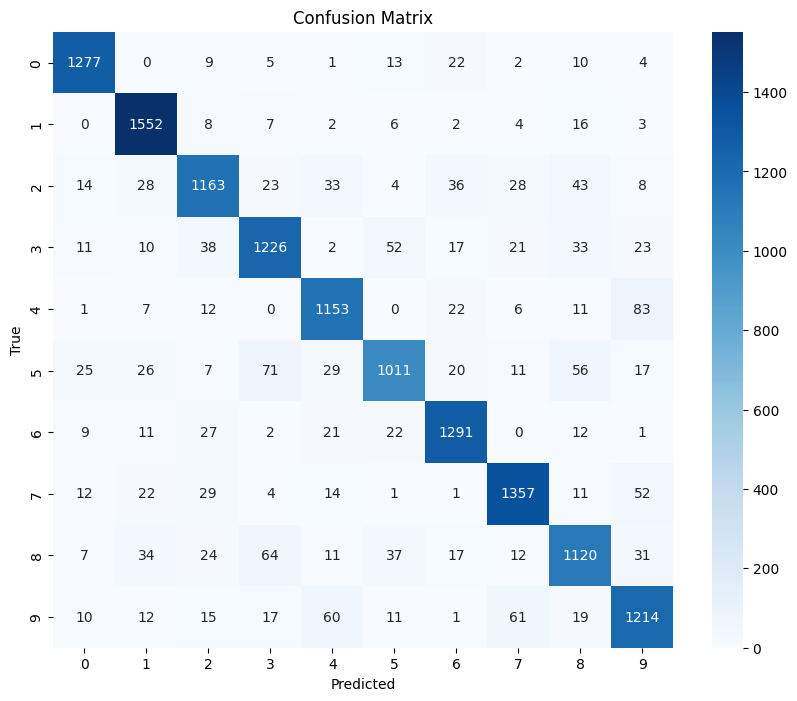

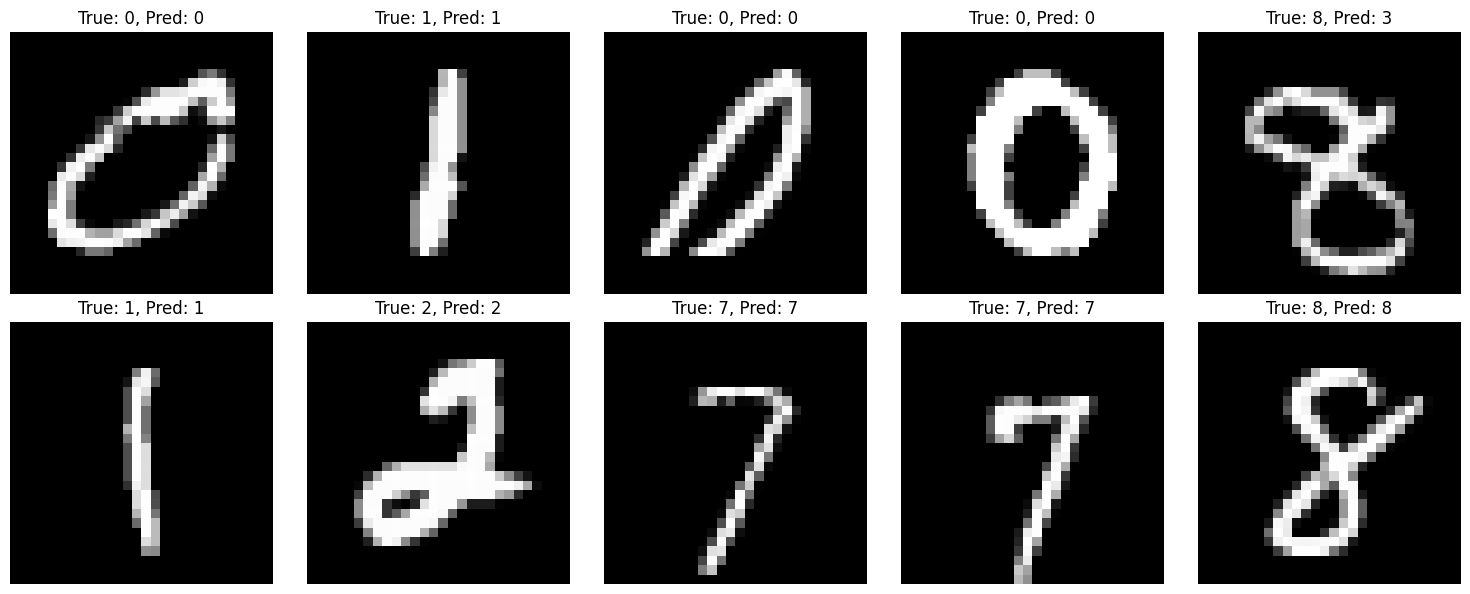


Training model with architecture: Shallow depth
Layers: [64, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1349 - val_loss: 1.9080
Epoch 2/20 [10.0%] - train_loss: 1.7146 - val_loss: 1.5387
Epoch 3/20 [15.0%] - train_loss: 1.3953 - val_loss: 1.2640
Epoch 4/20 [20.0%] - train_loss: 1.1634 - val_loss: 1.0690
Epoch 5/20 [25.0%] - train_loss: 0.9993 - val_loss: 0.9302
Epoch 6/20 [30.0%] - train_loss: 0.8817 - val_loss: 0.8296
Epoch 7/20 [35.0%] - train_loss: 0.7953 - val_loss: 0.7548
Epoch 8/20 [40.0%] - train_loss: 0.7300 - val_loss: 0.6976
Epoch 9/20 [45.0%] - train_loss: 0.6794 - val_loss: 0.6524
Epoch 10/20 [50.0%] - train_loss: 0.6389 - val_loss: 0.6160
Epoch 11/20 [55.0%] - train_loss: 0.6059 - val_loss: 0.5861
Epoch 12/20 [60.0%] - train_loss: 0.5785 - val_loss: 0.5610
Epoch 13/20 [65.0%] - train_loss: 0.5553 - val_loss: 0.5397
Epoch 14/20 [70.0%] - train_loss: 0.5354 - val_loss: 0.5214
Epoch 15/20 [75.0%] - train_loss: 0.5182 - val_loss: 0.5053
Epoch 16/20

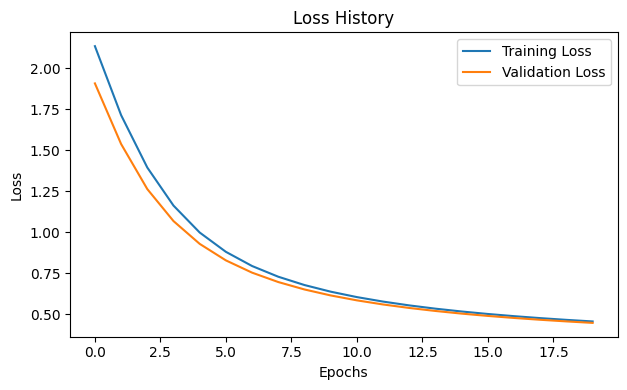


Evaluating model with Shallow depth [64, 10] activation...
Accuracy: 0.8825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.93      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.90      0.88      1295
           5       0.87      0.80      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.85      0.83      0.84      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



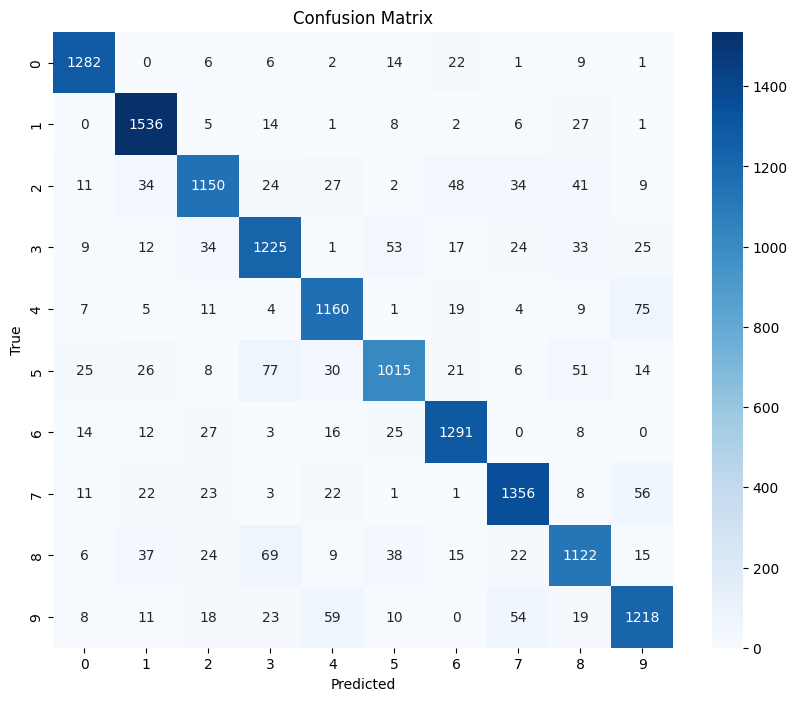

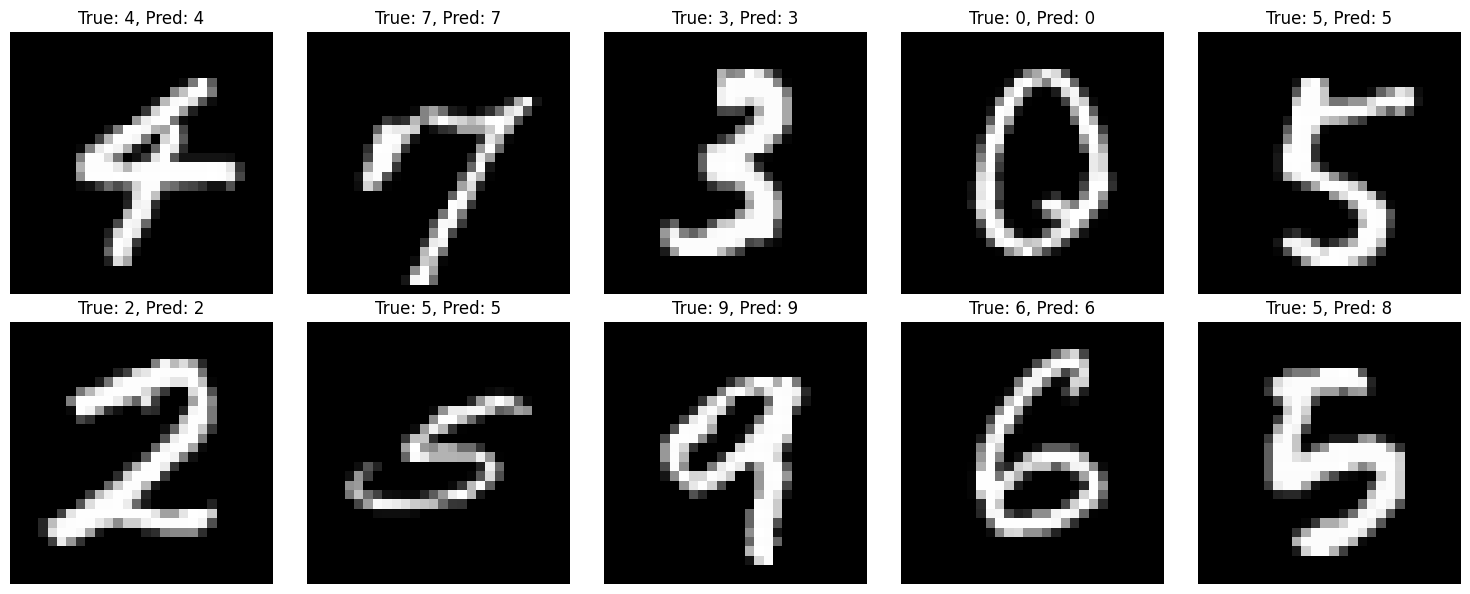


Training model with architecture: Medium depth
Layers: [64, 32, 10]
Activations: ['relu', 'relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0968 - val_loss: 1.8448
Epoch 2/20 [10.0%] - train_loss: 1.6291 - val_loss: 1.4279
Epoch 3/20 [15.0%] - train_loss: 1.2717 - val_loss: 1.1299
Epoch 4/20 [20.0%] - train_loss: 1.0333 - val_loss: 0.9425
Epoch 5/20 [25.0%] - train_loss: 0.8835 - val_loss: 0.8221
Epoch 6/20 [30.0%] - train_loss: 0.7836 - val_loss: 0.7385
Epoch 7/20 [35.0%] - train_loss: 0.7121 - val_loss: 0.6770
Epoch 8/20 [40.0%] - train_loss: 0.6577 - val_loss: 0.6293
Epoch 9/20 [45.0%] - train_loss: 0.6145 - val_loss: 0.5906
Epoch 10/20 [50.0%] - train_loss: 0.5791 - val_loss: 0.5586
Epoch 11/20 [55.0%] - train_loss: 0.5494 - val_loss: 0.5315
Epoch 12/20 [60.0%] - train_loss: 0.5241 - val_loss: 0.5086
Epoch 13/20 [65.0%] - train_loss: 0.5021 - val_loss: 0.4888
Epoch 14/20 [70.0%] - train_loss: 0.4829 - val_loss: 0.4714
Epoch 15/20 [75.0%] - train_loss: 0.4661 - val_loss: 0.4556


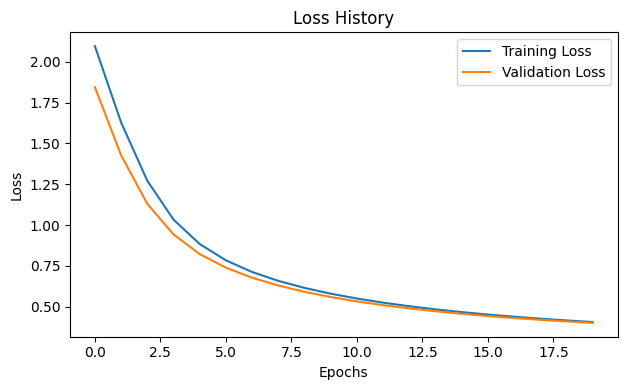


Evaluating model with Medium depth [64, 32, 10] activation...
Accuracy: 0.8910
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1343
           1       0.92      0.97      0.95      1600
           2       0.90      0.85      0.88      1380
           3       0.86      0.86      0.86      1433
           4       0.88      0.91      0.89      1295
           5       0.85      0.82      0.84      1273
           6       0.90      0.94      0.92      1396
           7       0.92      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.88      0.87      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



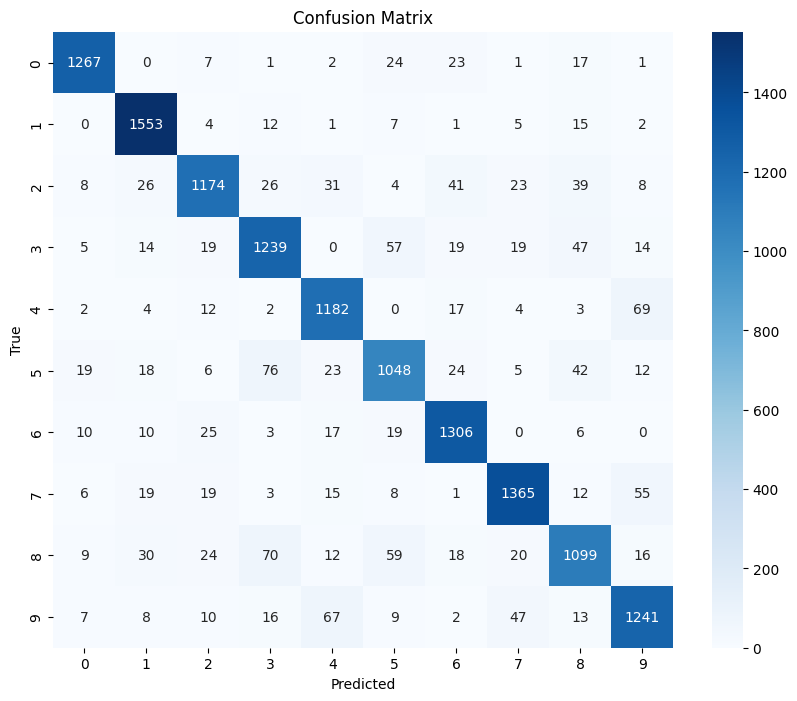

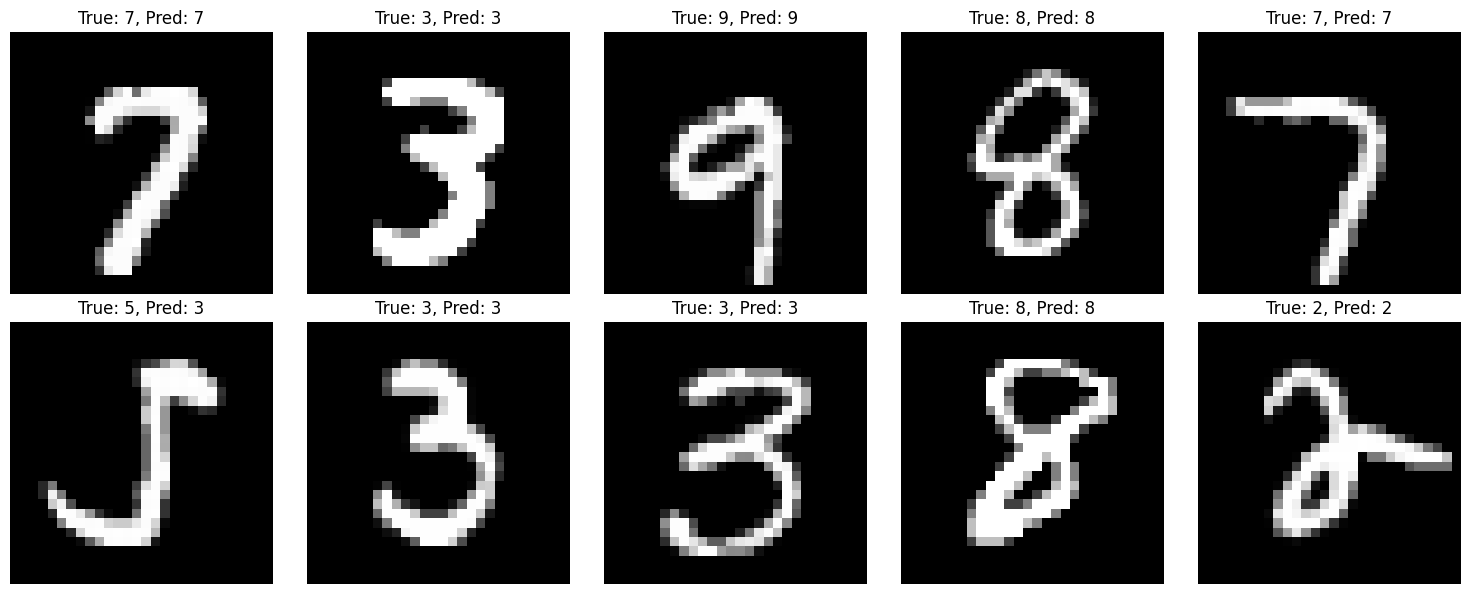


Training model with architecture: Deep network
Layers: [128, 64, 32, 10]
Activations: ['relu', 'relu', 'relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1465 - val_loss: 1.9462
Epoch 2/20 [10.0%] - train_loss: 1.7202 - val_loss: 1.4943
Epoch 3/20 [15.0%] - train_loss: 1.3058 - val_loss: 1.1358
Epoch 4/20 [20.0%] - train_loss: 1.0134 - val_loss: 0.9048
Epoch 5/20 [25.0%] - train_loss: 0.8279 - val_loss: 0.7559
Epoch 6/20 [30.0%] - train_loss: 0.7044 - val_loss: 0.6539
Epoch 7/20 [35.0%] - train_loss: 0.6185 - val_loss: 0.5828
Epoch 8/20 [40.0%] - train_loss: 0.5574 - val_loss: 0.5316
Epoch 9/20 [45.0%] - train_loss: 0.5123 - val_loss: 0.4928
Epoch 10/20 [50.0%] - train_loss: 0.4778 - val_loss: 0.4631
Epoch 11/20 [55.0%] - train_loss: 0.4507 - val_loss: 0.4396
Epoch 12/20 [60.0%] - train_loss: 0.4288 - val_loss: 0.4205
Epoch 13/20 [65.0%] - train_loss: 0.4107 - val_loss: 0.4048
Epoch 14/20 [70.0%] - train_loss: 0.3956 - val_loss: 0.3916
Epoch 15/20 [75.0%] - train_loss: 0.3827 - val_

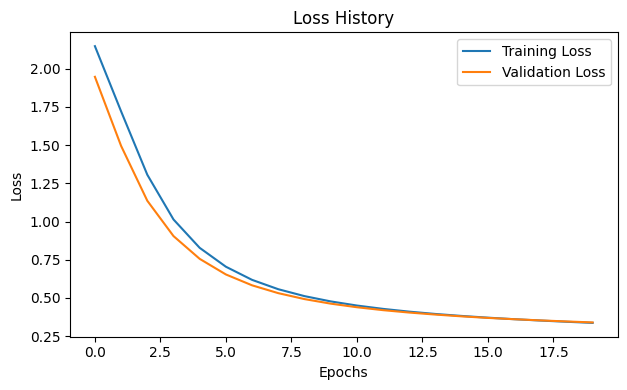


Evaluating model with Deep network [128, 64, 32, 10] activation...
Accuracy: 0.9040
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1343
           1       0.94      0.97      0.95      1600
           2       0.92      0.87      0.90      1380
           3       0.88      0.87      0.87      1433
           4       0.88      0.91      0.90      1295
           5       0.86      0.86      0.86      1273
           6       0.92      0.94      0.93      1396
           7       0.92      0.92      0.92      1503
           8       0.86      0.84      0.85      1357
           9       0.89      0.88      0.88      1420

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



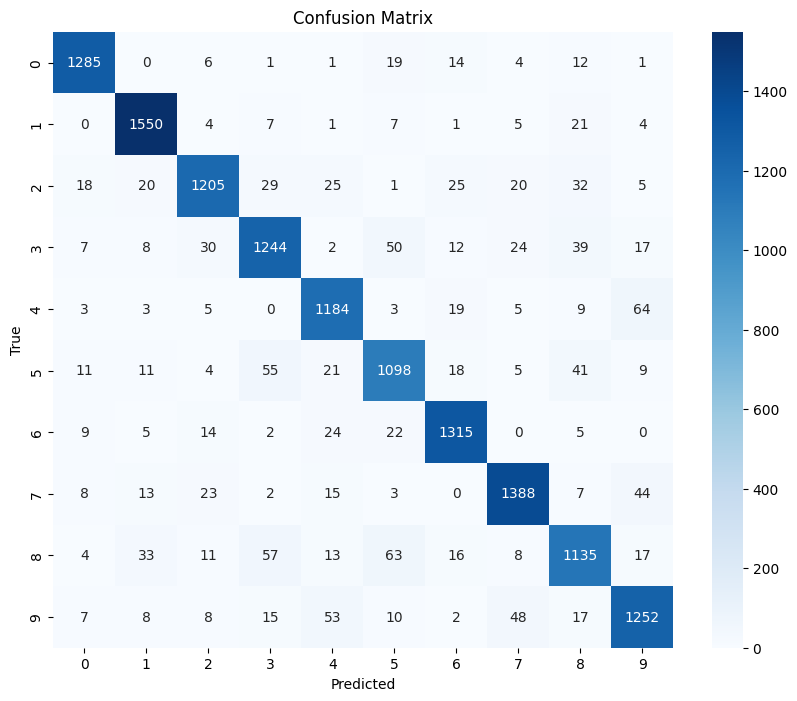

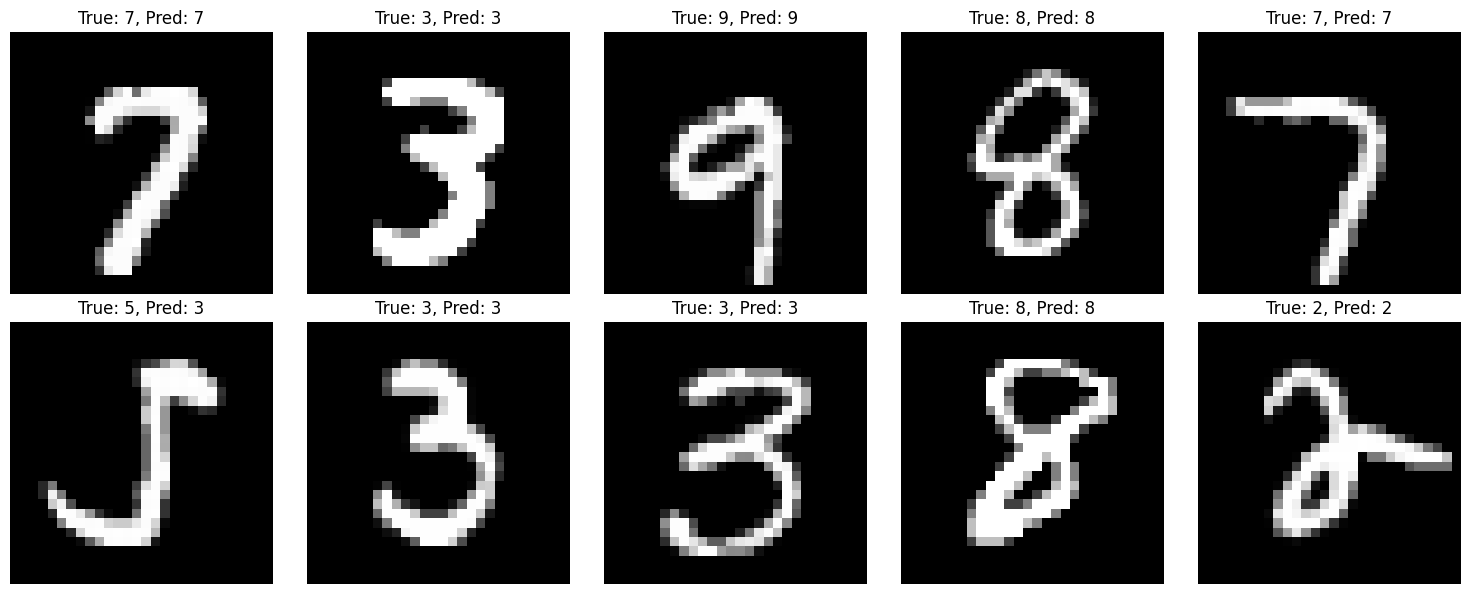


Activation Function Comparison Results:
                             name  accuracy  final_train_loss  final_val_loss  \
0            Small width [32, 10]  0.876357          0.472732        0.467809   
1           Medium width [64, 10]  0.882500          0.457522        0.448745   
2           Large width [128, 10]  0.883143          0.449202        0.445311   
3          Shallow depth [64, 10]  0.882500          0.457522        0.448745   
4       Medium depth [64, 32, 10]  0.891000          0.405075        0.399948   
5  Deep network [128, 64, 32, 10]  0.904000          0.337241        0.340229   

   training_time  
0      25.826034  
1      30.631998  
2      40.894742  
3      31.946117  
4      32.898258  
5      51.223317  

Activation Function Comparison Results:
                             name  accuracy  final_train_loss  final_val_loss  \
0            Small width [32, 10]  0.876357          0.472732        0.467809   
1           Medium width [64, 10]  0.882500          0.

In [11]:
width_results = []
depth_results = []

for i, arch in enumerate(architectures):
    print(f"\nTraining model with architecture: {arch['name']}")
    print(f"Layers: {arch['layers']}")
    print(f"Activations: {arch['activations']}")
    
    # Initialize the model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=arch['layers'],
        activations=arch['activations'],
        loss='categorical_cross_entropy',
        weight_init='he',
        weight_init_params={'seed': 42}
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)

    # Evaluate model
    print(f"\nEvaluating model with {arch['name']} {arch['layers']} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)

     # Store results
    width_results.append({
        'name': f"{arch['name']} {arch['layers']}",
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })
    depth_results.append({
        'name': f"{arch['name']} {arch['layers']}",
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })
    

print("\nActivation Function Comparison Results:")
widht_df = pd.DataFrame(width_results)
print(widht_df[['name', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

print("\nActivation Function Comparison Results:")
depth_df = pd.DataFrame(width_results)
print(depth_df[['name', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])
    

## Experiment 2 : Effect of Activation Function

In [12]:
activation_functions = ['linear', 'relu', 'sigmoid', 'tanh']

base_architecture = {
    'layers': [64, 32, 10],
    'loss': 'categorical_cross_entropy'
}

params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with activation: linear
Epoch 1/20 [5.0%] - train_loss: 1.6579 - val_loss: 1.1611
Epoch 2/20 [10.0%] - train_loss: 0.9717 - val_loss: 0.8304
Epoch 3/20 [15.0%] - train_loss: 0.7547 - val_loss: 0.6876
Epoch 4/20 [20.0%] - train_loss: 0.6473 - val_loss: 0.6074
Epoch 5/20 [25.0%] - train_loss: 0.5824 - val_loss: 0.5556
Epoch 6/20 [30.0%] - train_loss: 0.5384 - val_loss: 0.5192
Epoch 7/20 [35.0%] - train_loss: 0.5064 - val_loss: 0.4920
Epoch 8/20 [40.0%] - train_loss: 0.4819 - val_loss: 0.4709
Epoch 9/20 [45.0%] - train_loss: 0.4625 - val_loss: 0.4536
Epoch 10/20 [50.0%] - train_loss: 0.4466 - val_loss: 0.4396
Epoch 11/20 [55.0%] - train_loss: 0.4334 - val_loss: 0.4278
Epoch 12/20 [60.0%] - train_loss: 0.4222 - val_loss: 0.4178
Epoch 13/20 [65.0%] - train_loss: 0.4126 - val_loss: 0.4093
Epoch 14/20 [70.0%] - train_loss: 0.4042 - val_loss: 0.4017
Epoch 15/20 [75.0%] - train_loss: 0.3968 - val_loss: 0.3949
Epoch 16/20 [80.0%] - train_loss: 0.3902 - val_loss: 0.3890
Epoch 17/2

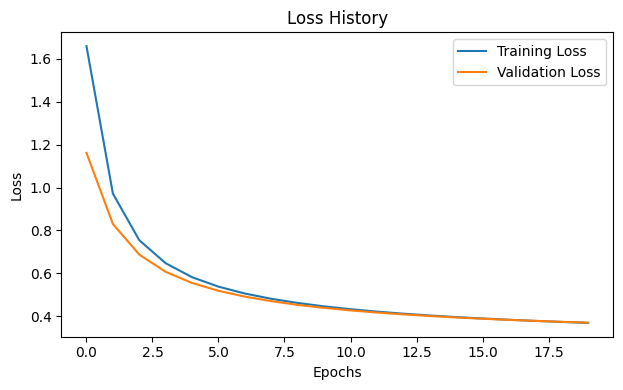


Evaluating model with linear activation...
Accuracy: 0.8948
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.93      0.96      0.94      1600
           2       0.89      0.86      0.87      1380
           3       0.87      0.88      0.87      1433
           4       0.89      0.92      0.90      1295
           5       0.86      0.83      0.84      1273
           6       0.92      0.93      0.93      1396
           7       0.91      0.91      0.91      1503
           8       0.85      0.82      0.84      1357
           9       0.87      0.88      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



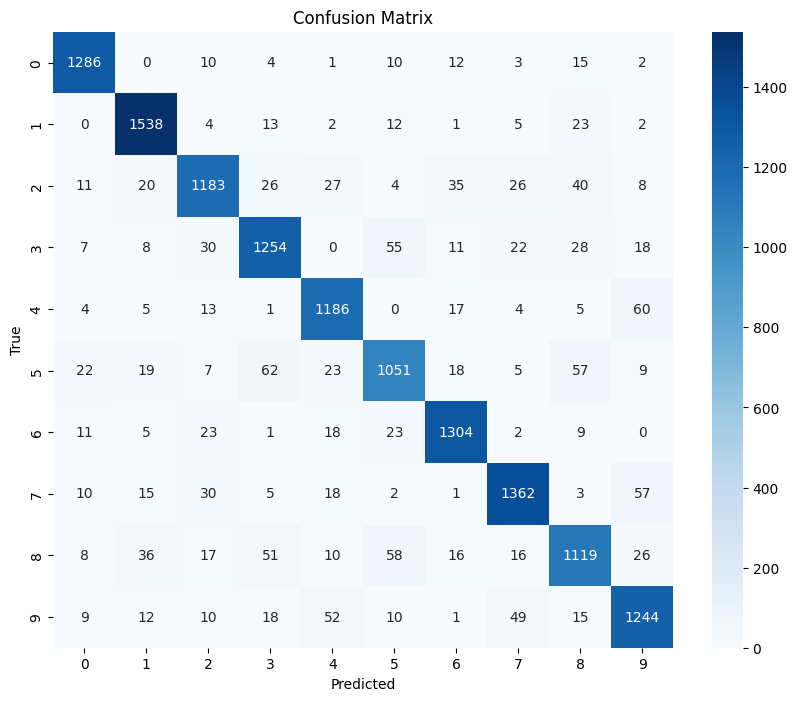

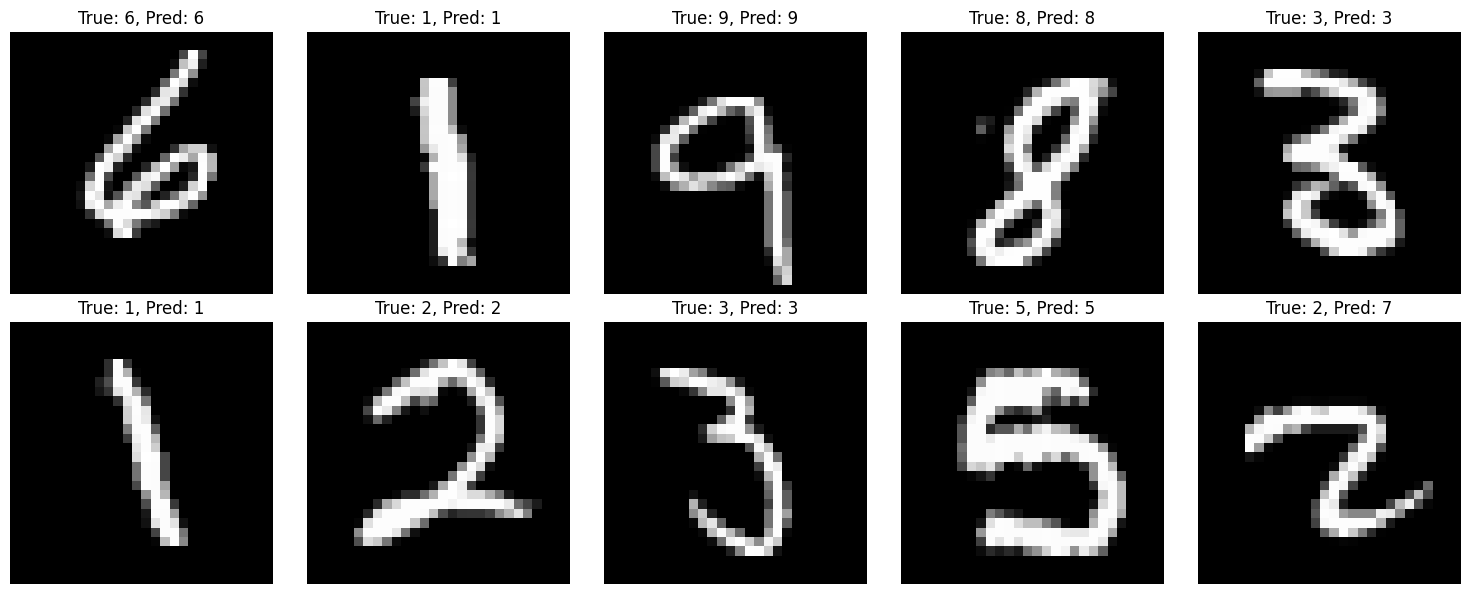


Weight distributions:


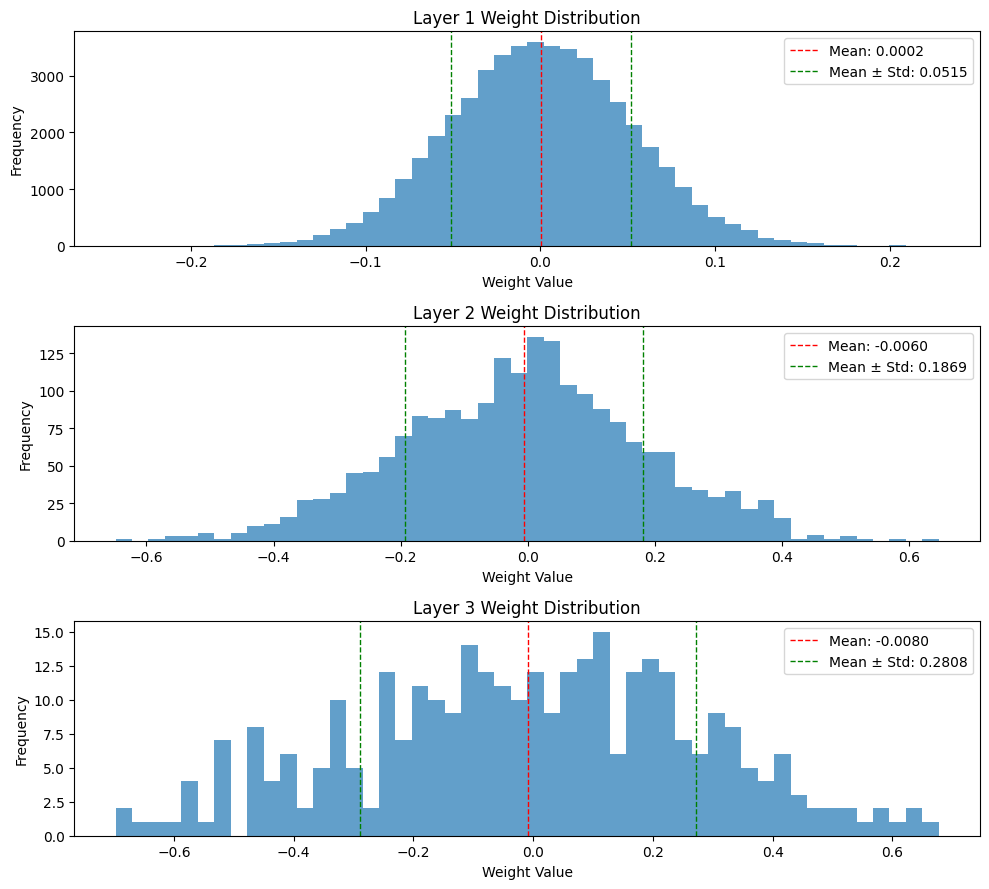


Gradient distributions:


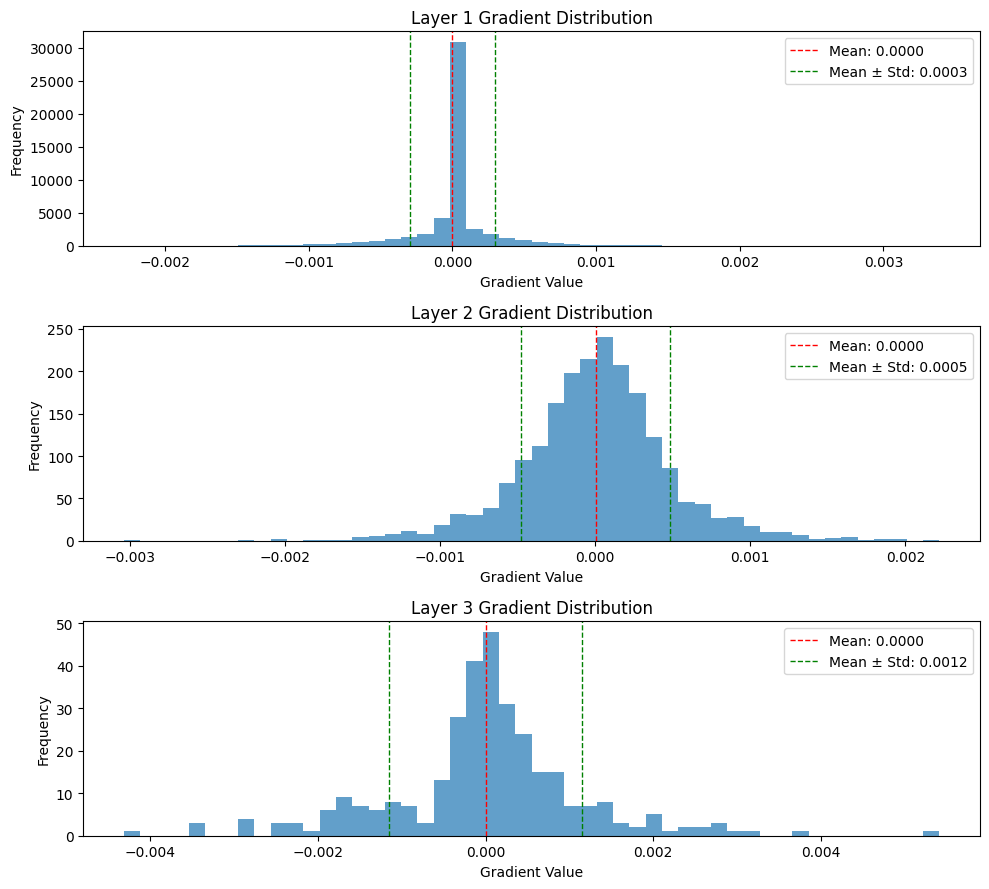


Training model with activation: relu
Epoch 1/20 [5.0%] - train_loss: 2.1180 - val_loss: 1.9161
Epoch 2/20 [10.0%] - train_loss: 1.7458 - val_loss: 1.5832
Epoch 3/20 [15.0%] - train_loss: 1.4312 - val_loss: 1.2799
Epoch 4/20 [20.0%] - train_loss: 1.1564 - val_loss: 1.0378
Epoch 5/20 [25.0%] - train_loss: 0.9552 - val_loss: 0.8712
Epoch 6/20 [30.0%] - train_loss: 0.8179 - val_loss: 0.7580
Epoch 7/20 [35.0%] - train_loss: 0.7225 - val_loss: 0.6783
Epoch 8/20 [40.0%] - train_loss: 0.6538 - val_loss: 0.6197
Epoch 9/20 [45.0%] - train_loss: 0.6024 - val_loss: 0.5753
Epoch 10/20 [50.0%] - train_loss: 0.5626 - val_loss: 0.5404
Epoch 11/20 [55.0%] - train_loss: 0.5310 - val_loss: 0.5124
Epoch 12/20 [60.0%] - train_loss: 0.5051 - val_loss: 0.4893
Epoch 13/20 [65.0%] - train_loss: 0.4836 - val_loss: 0.4696
Epoch 14/20 [70.0%] - train_loss: 0.4652 - val_loss: 0.4530
Epoch 15/20 [75.0%] - train_loss: 0.4494 - val_loss: 0.4386
Epoch 16/20 [80.0%] - train_loss: 0.4357 - val_loss: 0.4259
Epoch 17/20 

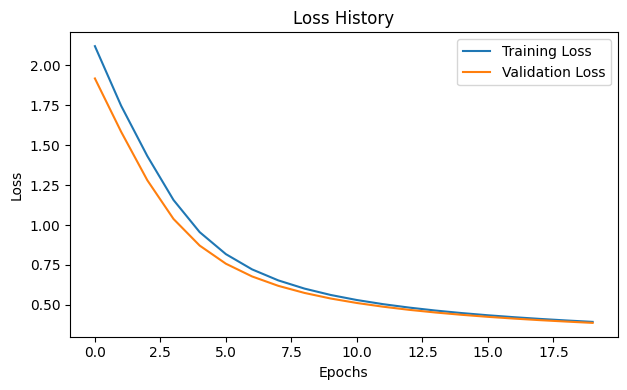


Evaluating model with relu activation...
Accuracy: 0.8918
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1343
           1       0.92      0.97      0.95      1600
           2       0.89      0.85      0.87      1380
           3       0.86      0.86      0.86      1433
           4       0.89      0.90      0.89      1295
           5       0.86      0.80      0.83      1273
           6       0.89      0.93      0.91      1396
           7       0.91      0.92      0.91      1503
           8       0.86      0.82      0.84      1357
           9       0.87      0.87      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



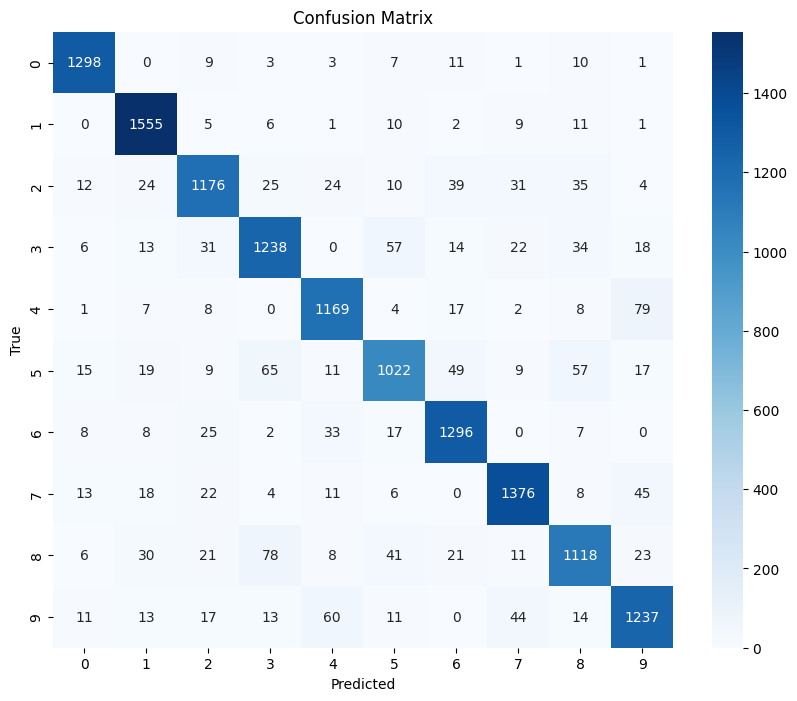

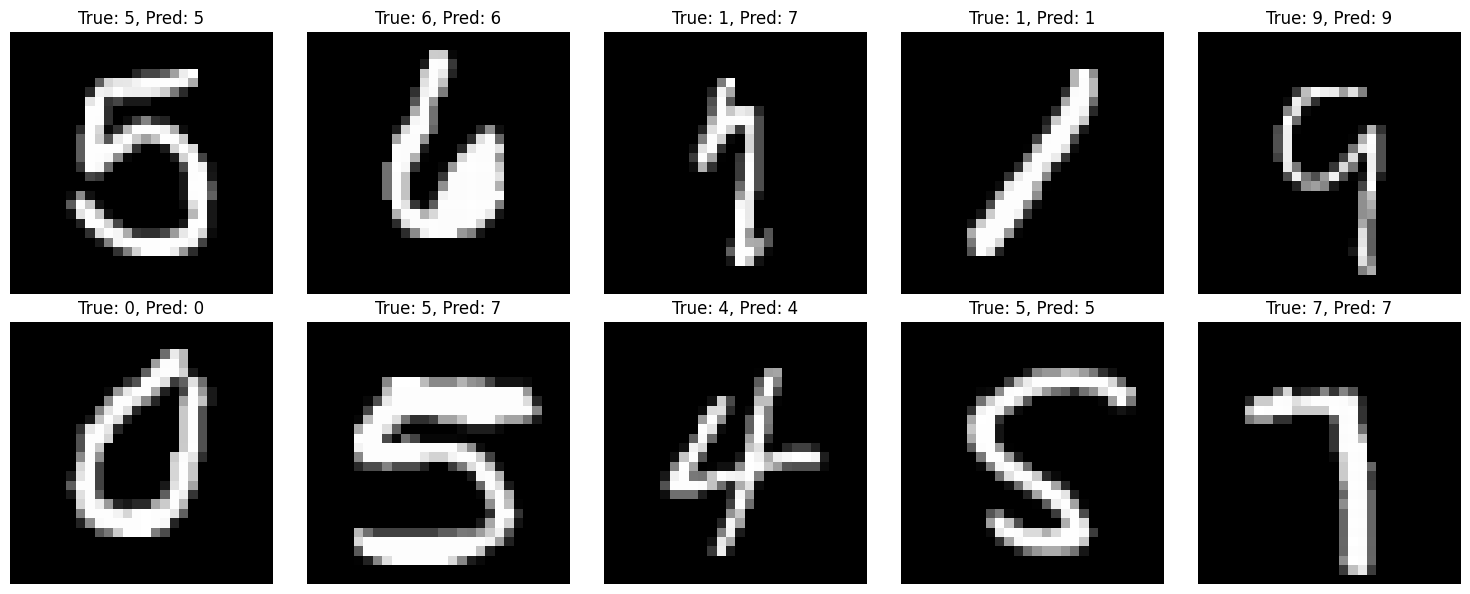


Weight distributions:


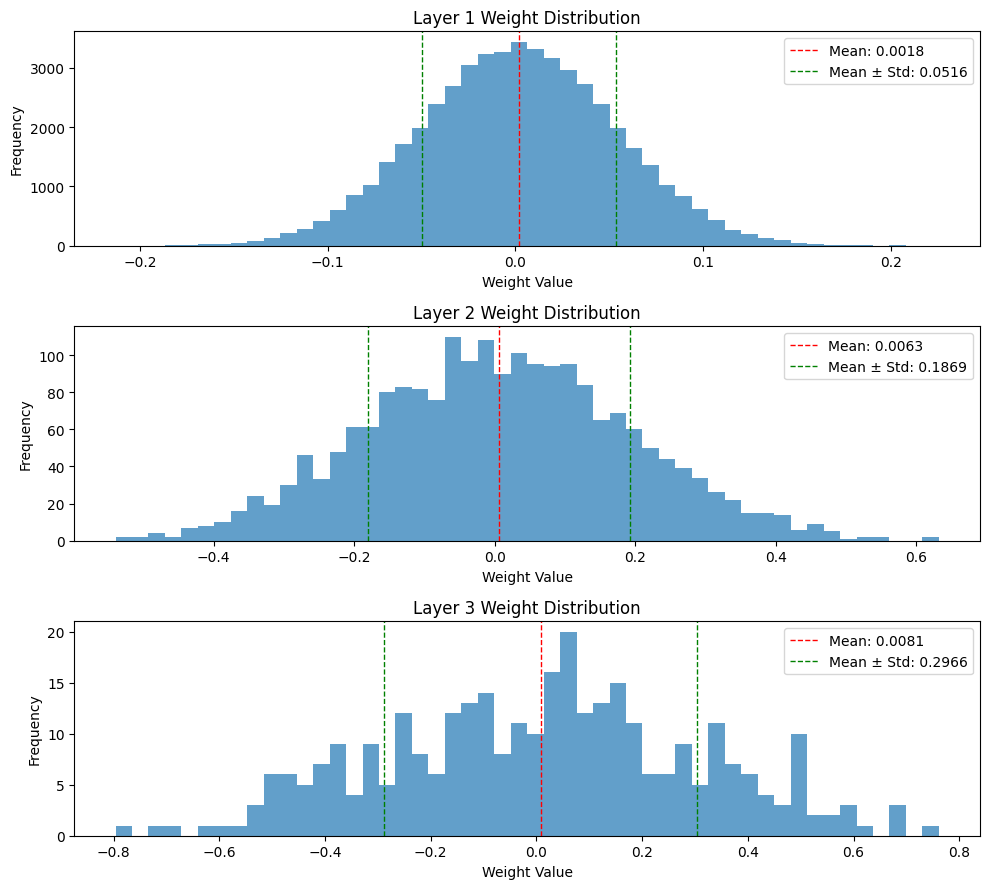


Gradient distributions:


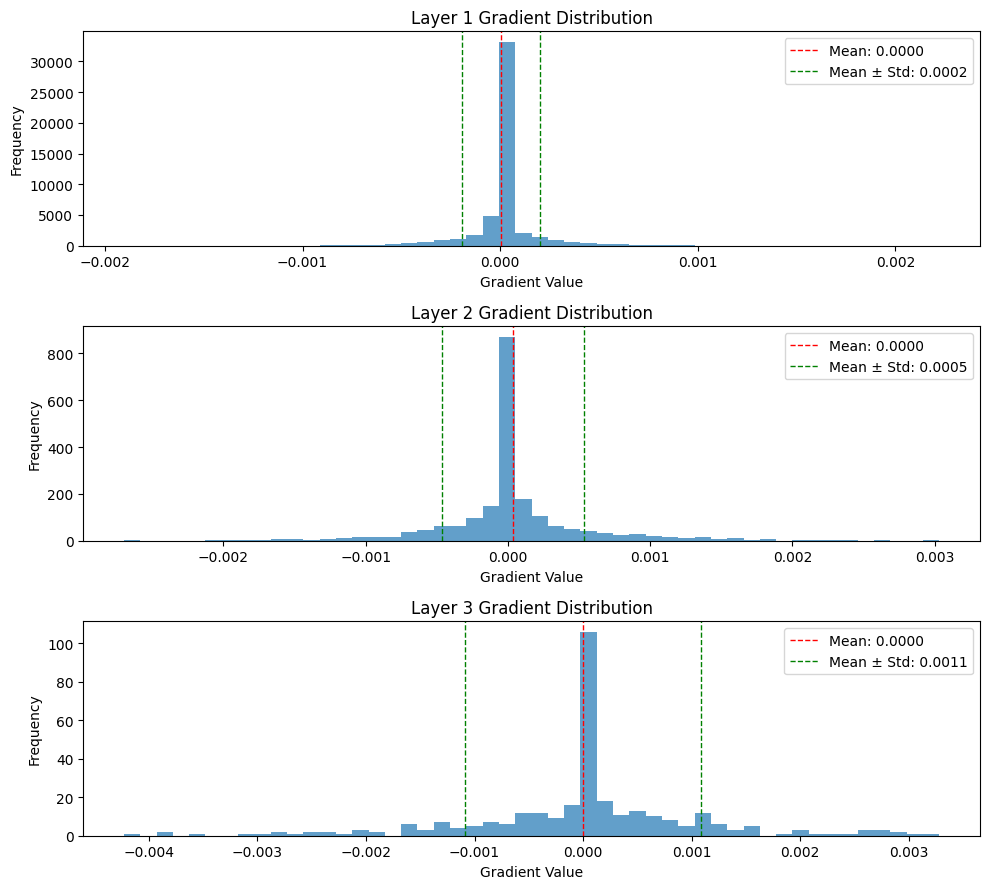


Training model with activation: sigmoid
Epoch 1/20 [5.0%] - train_loss: 2.4622 - val_loss: 2.3736
Epoch 2/20 [10.0%] - train_loss: 2.3401 - val_loss: 2.3151
Epoch 3/20 [15.0%] - train_loss: 2.3033 - val_loss: 2.2931
Epoch 4/20 [20.0%] - train_loss: 2.2872 - val_loss: 2.2815
Epoch 5/20 [25.0%] - train_loss: 2.2775 - val_loss: 2.2733
Epoch 6/20 [30.0%] - train_loss: 2.2699 - val_loss: 2.2661
Epoch 7/20 [35.0%] - train_loss: 2.2630 - val_loss: 2.2593
Epoch 8/20 [40.0%] - train_loss: 2.2563 - val_loss: 2.2526
Epoch 9/20 [45.0%] - train_loss: 2.2495 - val_loss: 2.2457
Epoch 10/20 [50.0%] - train_loss: 2.2425 - val_loss: 2.2387
Epoch 11/20 [55.0%] - train_loss: 2.2355 - val_loss: 2.2315
Epoch 12/20 [60.0%] - train_loss: 2.2282 - val_loss: 2.2242
Epoch 13/20 [65.0%] - train_loss: 2.2208 - val_loss: 2.2166
Epoch 14/20 [70.0%] - train_loss: 2.2132 - val_loss: 2.2088
Epoch 15/20 [75.0%] - train_loss: 2.2053 - val_loss: 2.2008
Epoch 16/20 [80.0%] - train_loss: 2.1971 - val_loss: 2.1925
Epoch 17/

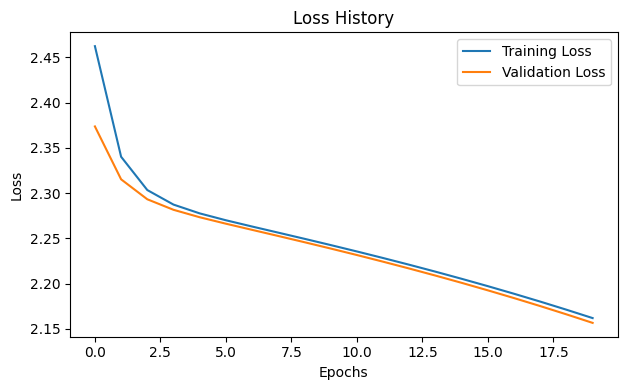


Evaluating model with sigmoid activation...
Accuracy: 0.5521
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1343
           1       0.35      0.99      0.52      1600
           2       0.79      0.44      0.57      1380
           3       0.56      0.64      0.60      1433
           4       0.77      0.46      0.58      1295
           5       1.00      0.00      0.00      1273
           6       0.82      0.75      0.78      1396
           7       0.44      0.92      0.59      1503
           8       0.80      0.35      0.49      1357
           9       0.55      0.05      0.10      1420

    accuracy                           0.55     14000
   macro avg       0.70      0.54      0.51     14000
weighted avg       0.69      0.55      0.51     14000



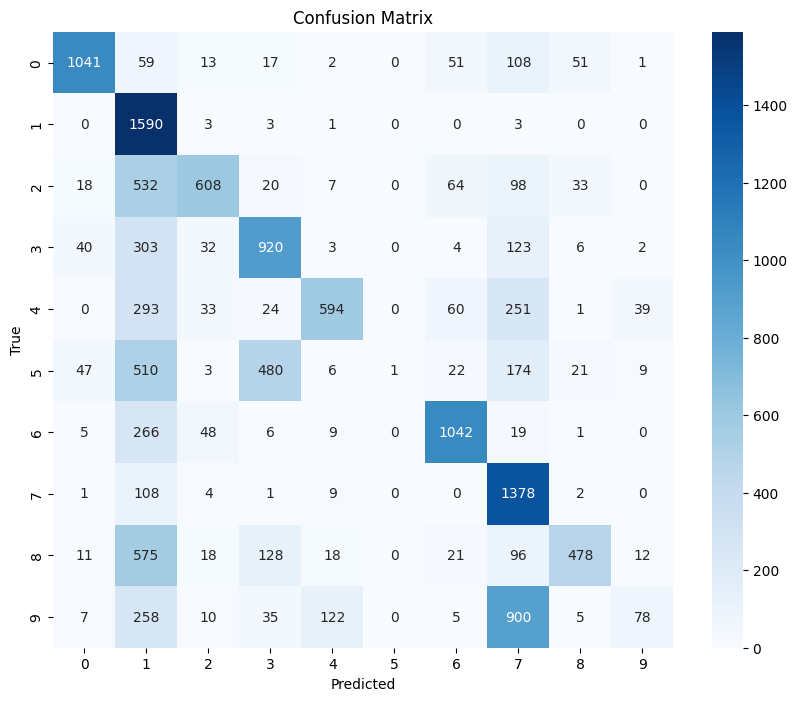

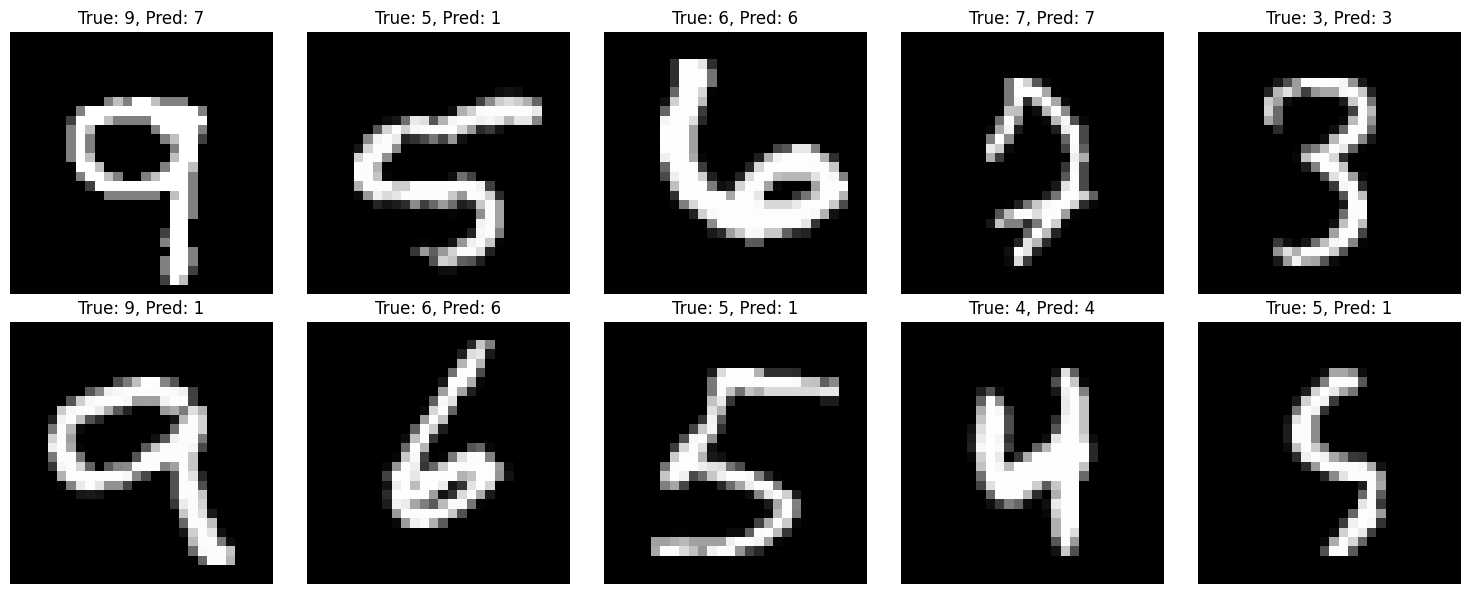


Weight distributions:


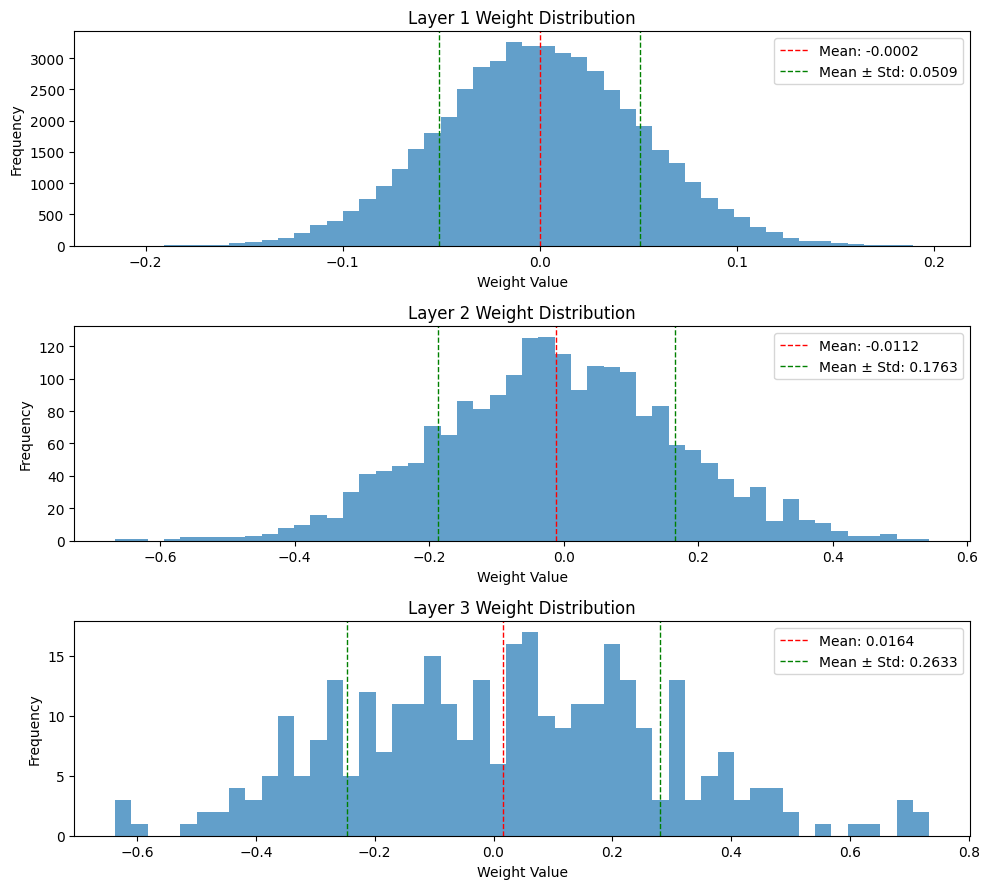


Gradient distributions:


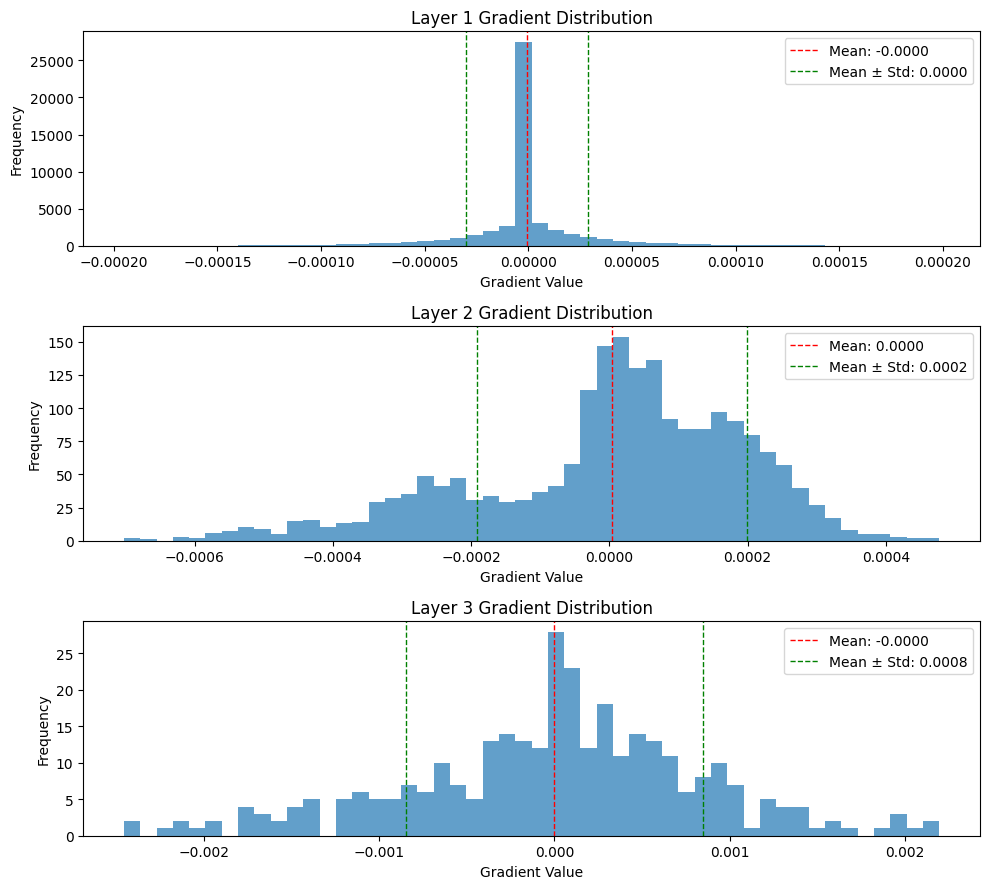


Training model with activation: tanh
Epoch 1/20 [5.0%] - train_loss: 1.9759 - val_loss: 1.6193
Epoch 2/20 [10.0%] - train_loss: 1.4217 - val_loss: 1.2565
Epoch 3/20 [15.0%] - train_loss: 1.1522 - val_loss: 1.0555
Epoch 4/20 [20.0%] - train_loss: 0.9904 - val_loss: 0.9257
Epoch 5/20 [25.0%] - train_loss: 0.8807 - val_loss: 0.8339
Epoch 6/20 [30.0%] - train_loss: 0.8009 - val_loss: 0.7655
Epoch 7/20 [35.0%] - train_loss: 0.7401 - val_loss: 0.7123
Epoch 8/20 [40.0%] - train_loss: 0.6919 - val_loss: 0.6696
Epoch 9/20 [45.0%] - train_loss: 0.6528 - val_loss: 0.6346
Epoch 10/20 [50.0%] - train_loss: 0.6203 - val_loss: 0.6052
Epoch 11/20 [55.0%] - train_loss: 0.5928 - val_loss: 0.5803
Epoch 12/20 [60.0%] - train_loss: 0.5693 - val_loss: 0.5588
Epoch 13/20 [65.0%] - train_loss: 0.5489 - val_loss: 0.5399
Epoch 14/20 [70.0%] - train_loss: 0.5310 - val_loss: 0.5234
Epoch 15/20 [75.0%] - train_loss: 0.5151 - val_loss: 0.5087
Epoch 16/20 [80.0%] - train_loss: 0.5009 - val_loss: 0.4956
Epoch 17/20 

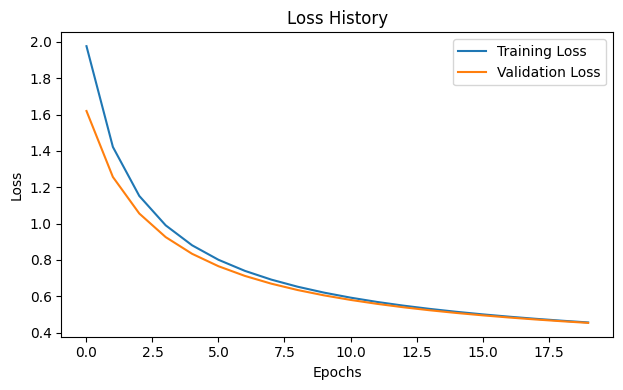


Evaluating model with tanh activation...
Accuracy: 0.8849
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1343
           1       0.91      0.96      0.94      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.87      0.86      1433
           4       0.88      0.89      0.89      1295
           5       0.85      0.81      0.83      1273
           6       0.91      0.93      0.92      1396
           7       0.90      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.86      0.87      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



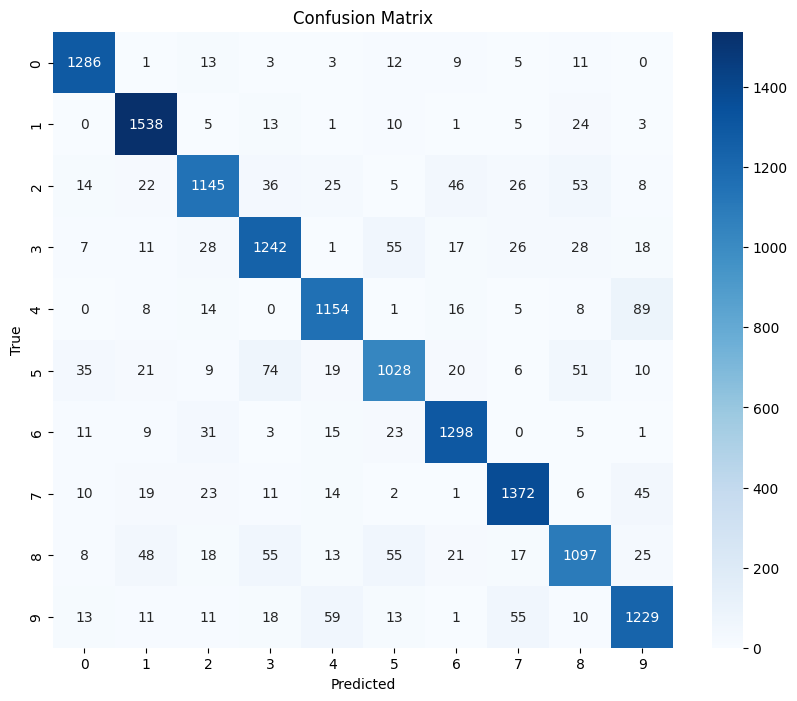

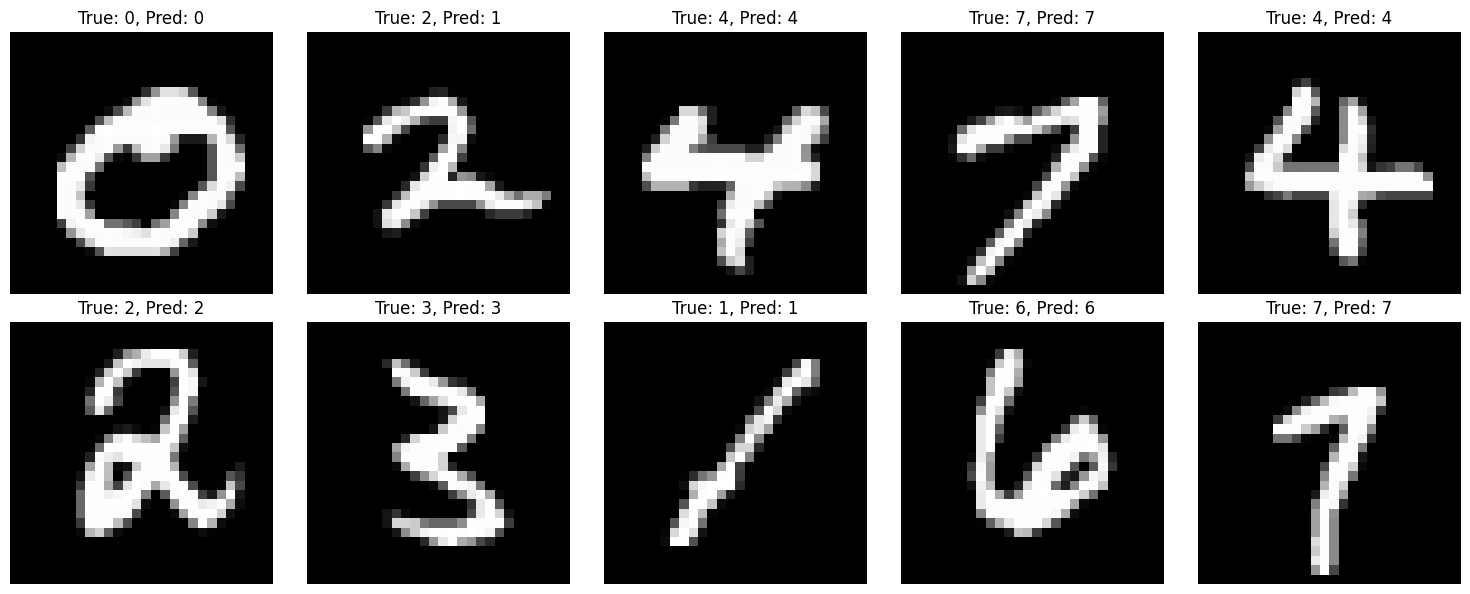


Weight distributions:


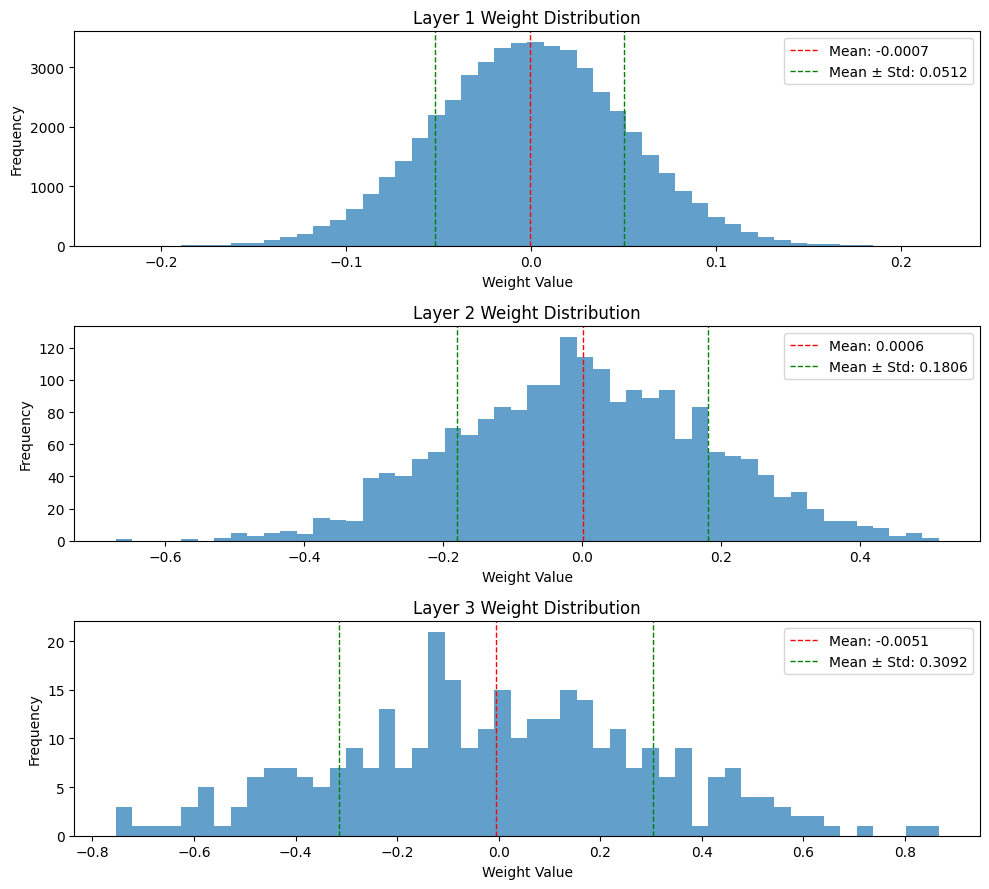


Gradient distributions:


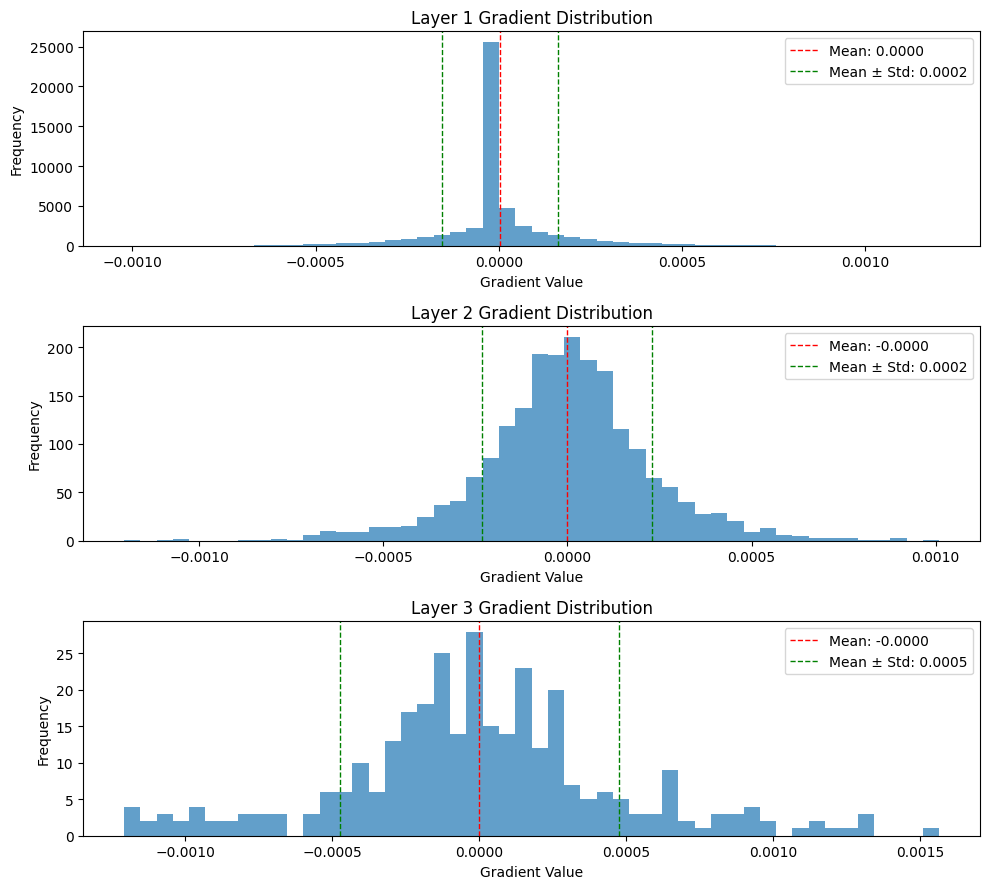


Activation Function Comparison Results:
  activation  accuracy  final_train_loss  final_val_loss  training_time
0     linear  0.894786          0.369739        0.370755      31.429600
1       relu  0.891786          0.394382        0.388035      31.099354
2    sigmoid  0.552143          2.161883        2.156583      34.238079
3       tanh  0.884929          0.456399        0.453952      34.596420


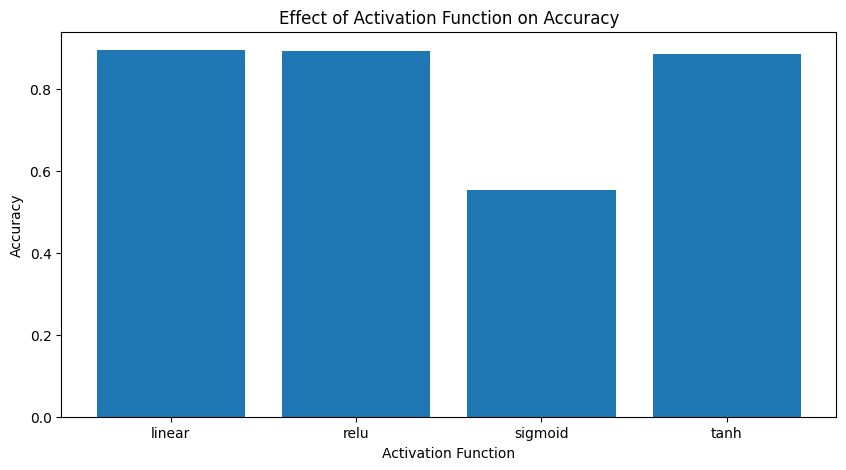

In [13]:
activation_results = []

for activation in activation_functions:
    print(f"\nTraining model with activation: {activation}")
    
    # Create activations list (softmax for output layer)
    activations = [activation] * (len(base_architecture['layers']) - 1) + ['softmax']
    
    # Initialize model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=activations,
        loss=base_architecture['loss']
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)
    
    # Evaluate model
    print(f"\nEvaluating model with {activation} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    # Plot weight and gradient distributions
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    # Store results
    activation_results.append({
        'activation': activation,
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display activation results
print("\nActivation Function Comparison Results:")
activation_df = pd.DataFrame(activation_results)
print(activation_df[['activation', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

# Plot comparative results
plt.figure(figsize=(10, 5))
plt.bar([r['activation'] for r in activation_results], [r['accuracy'] for r in activation_results])
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Effect of Activation Function on Accuracy')
plt.show()

## Experiment 3 : Effect of learning rate

In [9]:
learning_rates = [0.001, 0.01, 0.1]

base_architecture = {
    'layers': [64, 32, 10],
    'activations': ['relu', 'relu', 'softmax'],
    'loss': 'categorical_cross_entropy'
}
params = {
    'epochs': 20,
    'batch_size': 32
}


Training model with learning rate: 0.001
Epoch 1/20 [5.0%] - train_loss: 2.3850 - val_loss: 2.3434
Epoch 2/20 [10.0%] - train_loss: 2.3221 - val_loss: 2.2896
Epoch 3/20 [15.0%] - train_loss: 2.2730 - val_loss: 2.2455
Epoch 4/20 [20.0%] - train_loss: 2.2320 - val_loss: 2.2074
Epoch 5/20 [25.0%] - train_loss: 2.1957 - val_loss: 2.1730
Epoch 6/20 [30.0%] - train_loss: 2.1625 - val_loss: 2.1409
Epoch 7/20 [35.0%] - train_loss: 2.1308 - val_loss: 2.1099
Epoch 8/20 [40.0%] - train_loss: 2.0998 - val_loss: 2.0790
Epoch 9/20 [45.0%] - train_loss: 2.0686 - val_loss: 2.0479
Epoch 10/20 [50.0%] - train_loss: 2.0368 - val_loss: 2.0160
Epoch 11/20 [55.0%] - train_loss: 2.0041 - val_loss: 1.9831
Epoch 12/20 [60.0%] - train_loss: 1.9703 - val_loss: 1.9491
Epoch 13/20 [65.0%] - train_loss: 1.9354 - val_loss: 1.9142
Epoch 14/20 [70.0%] - train_loss: 1.8997 - val_loss: 1.8783
Epoch 15/20 [75.0%] - train_loss: 1.8631 - val_loss: 1.8418
Epoch 16/20 [80.0%] - train_loss: 1.8261 - val_loss: 1.8048
Epoch 17

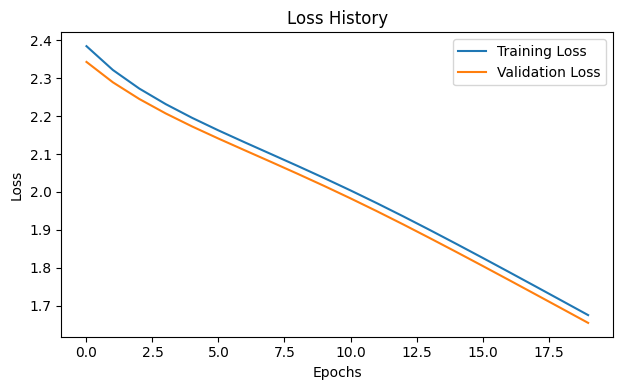


Evaluating model with learning rate 0.001...
Accuracy: 0.5079
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.36      0.51      1343
           1       0.90      0.73      0.81      1600
           2       0.40      0.83      0.54      1380
           3       0.45      0.79      0.58      1433
           4       0.53      0.40      0.45      1295
           5       0.25      0.07      0.11      1273
           6       0.85      0.10      0.17      1396
           7       0.53      0.85      0.65      1503
           8       0.57      0.30      0.40      1357
           9       0.35      0.54      0.42      1420

    accuracy                           0.51     14000
   macro avg       0.57      0.50      0.46     14000
weighted avg       0.58      0.51      0.47     14000



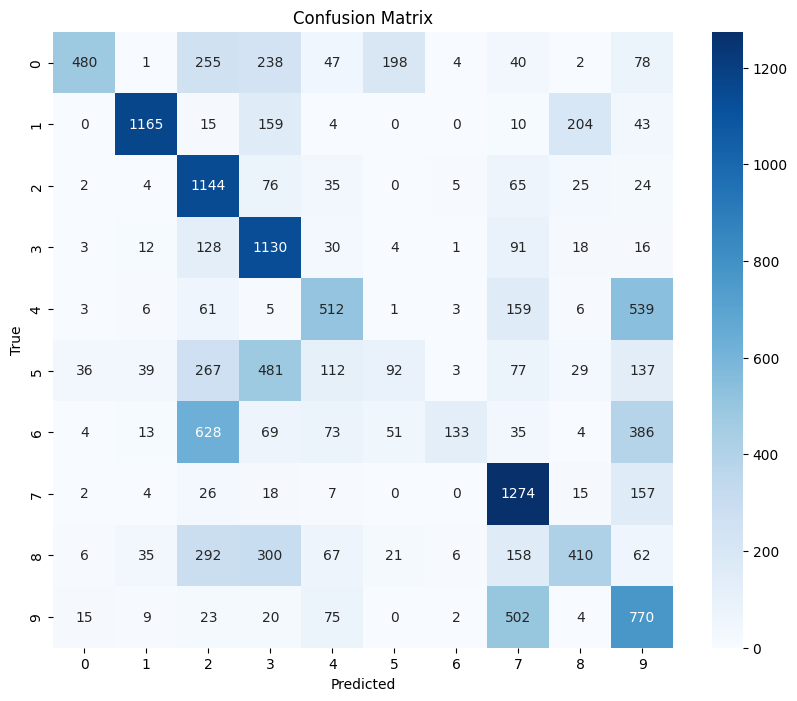

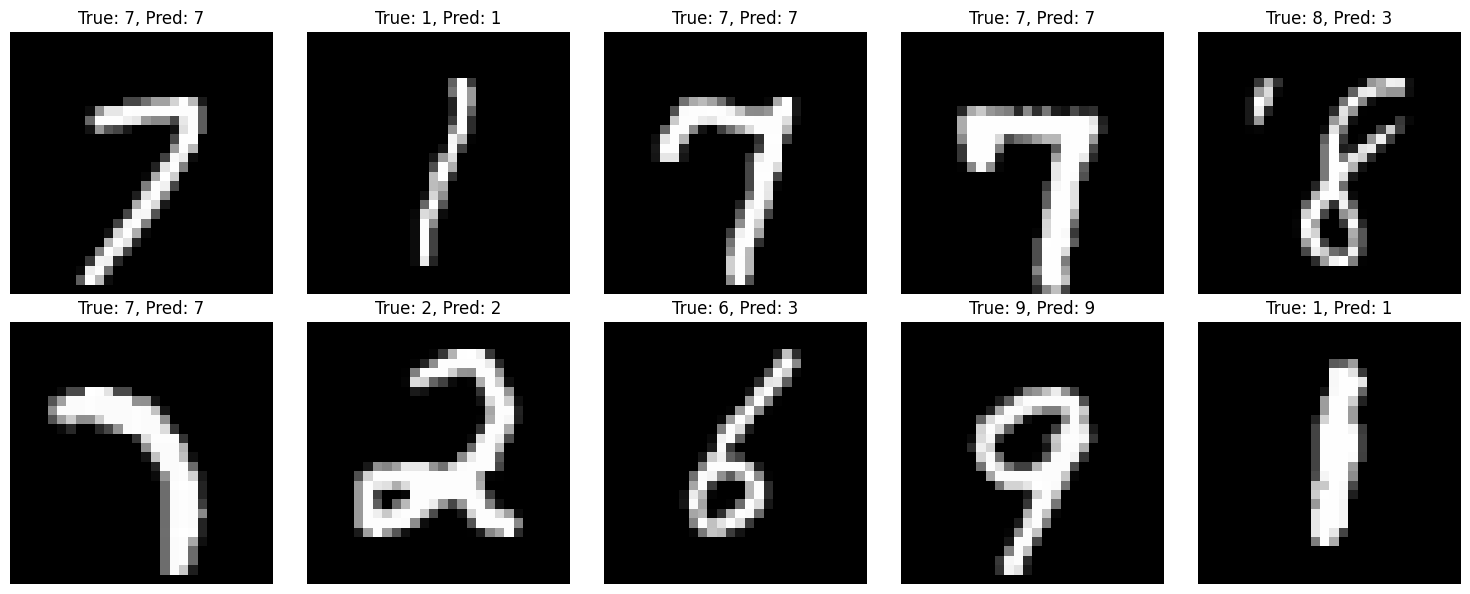


Weight distributions:


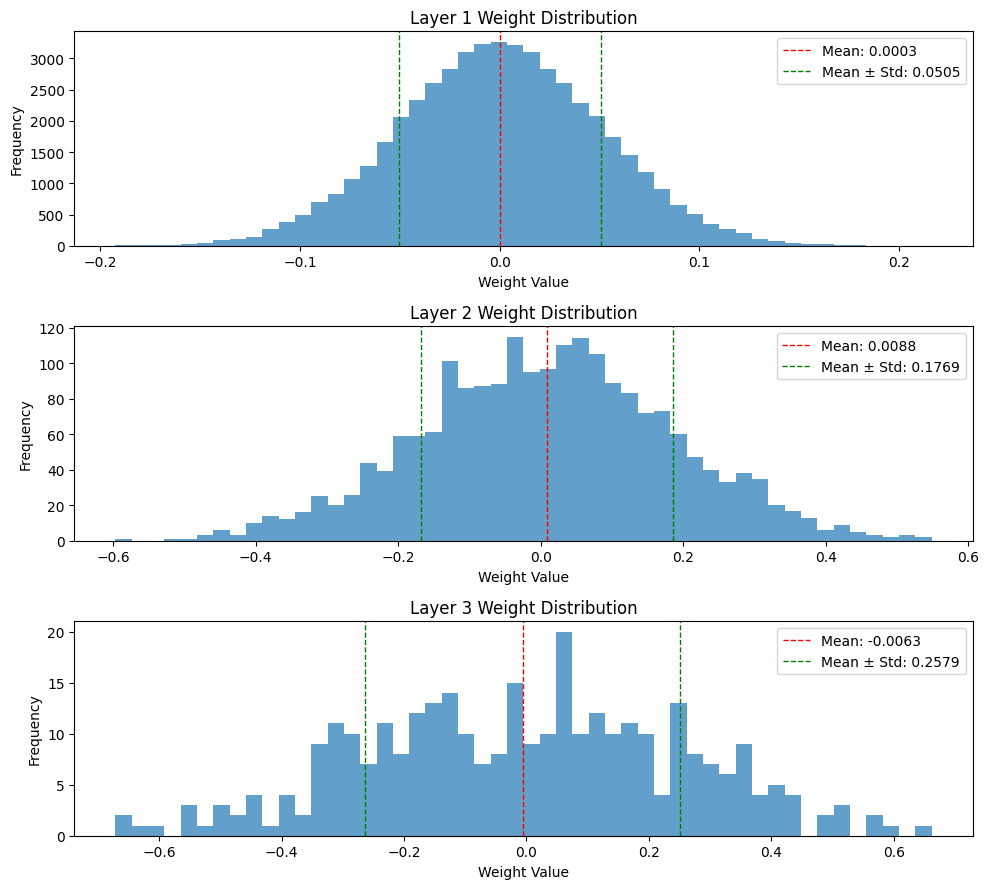


Gradient distributions:


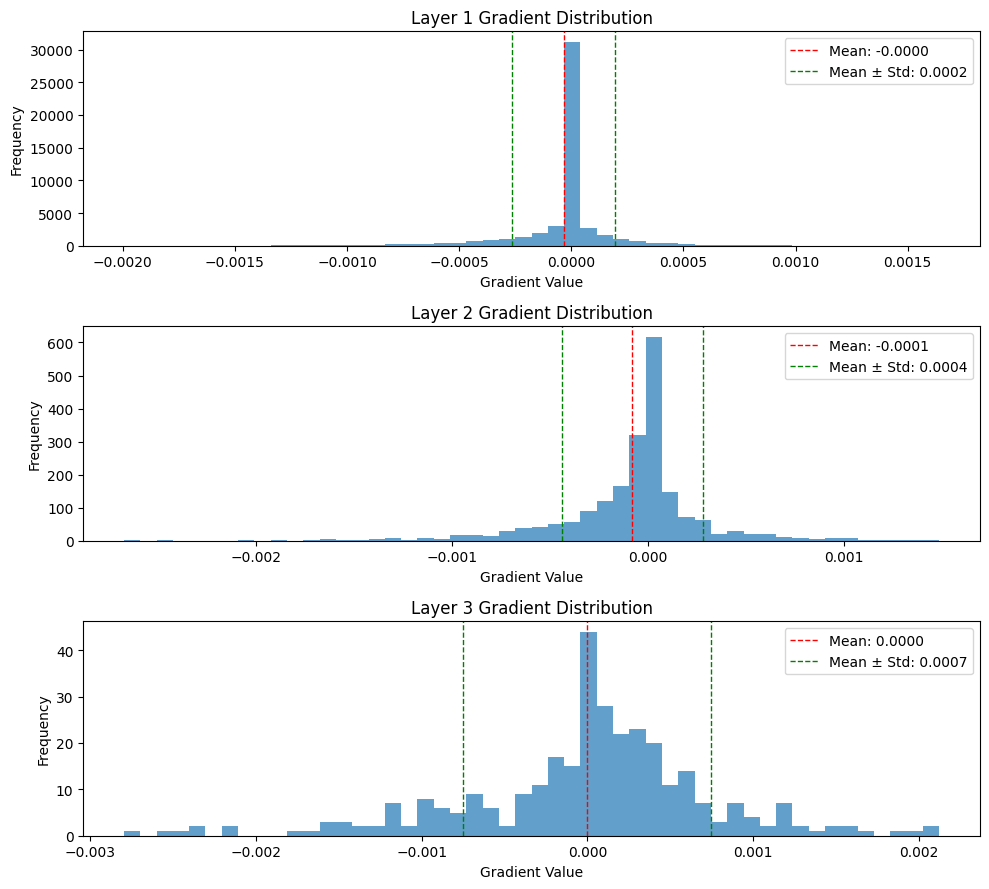


Training model with learning rate: 0.01
Epoch 1/20 [5.0%] - train_loss: 2.1776 - val_loss: 1.9833
Epoch 2/20 [10.0%] - train_loss: 1.7998 - val_loss: 1.6278
Epoch 3/20 [15.0%] - train_loss: 1.4520 - val_loss: 1.2963
Epoch 4/20 [20.0%] - train_loss: 1.1592 - val_loss: 1.0457
Epoch 5/20 [25.0%] - train_loss: 0.9531 - val_loss: 0.8777
Epoch 6/20 [30.0%] - train_loss: 0.8142 - val_loss: 0.7629
Epoch 7/20 [35.0%] - train_loss: 0.7174 - val_loss: 0.6812
Epoch 8/20 [40.0%] - train_loss: 0.6470 - val_loss: 0.6205
Epoch 9/20 [45.0%] - train_loss: 0.5938 - val_loss: 0.5740
Epoch 10/20 [50.0%] - train_loss: 0.5523 - val_loss: 0.5372
Epoch 11/20 [55.0%] - train_loss: 0.5193 - val_loss: 0.5077
Epoch 12/20 [60.0%] - train_loss: 0.4924 - val_loss: 0.4836
Epoch 13/20 [65.0%] - train_loss: 0.4701 - val_loss: 0.4634
Epoch 14/20 [70.0%] - train_loss: 0.4515 - val_loss: 0.4464
Epoch 15/20 [75.0%] - train_loss: 0.4355 - val_loss: 0.4320
Epoch 16/20 [80.0%] - train_loss: 0.4217 - val_loss: 0.4193
Epoch 17/

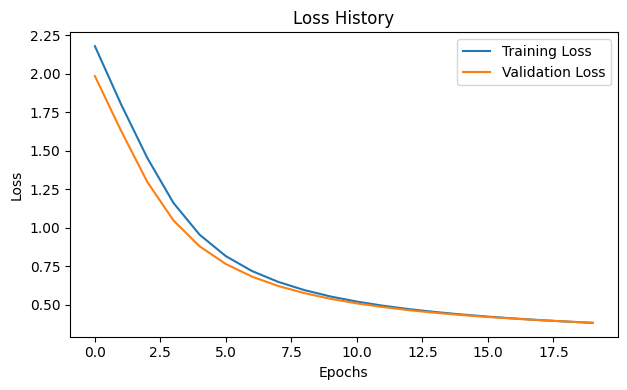


Evaluating model with learning rate 0.01...
Accuracy: 0.8961
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.93      0.96      0.95      1600
           2       0.89      0.87      0.88      1380
           3       0.86      0.87      0.87      1433
           4       0.88      0.88      0.88      1295
           5       0.86      0.82      0.84      1273
           6       0.93      0.93      0.93      1396
           7       0.93      0.92      0.92      1503
           8       0.87      0.84      0.86      1357
           9       0.86      0.88      0.87      1420

    accuracy                           0.90     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.90      0.90      0.90     14000



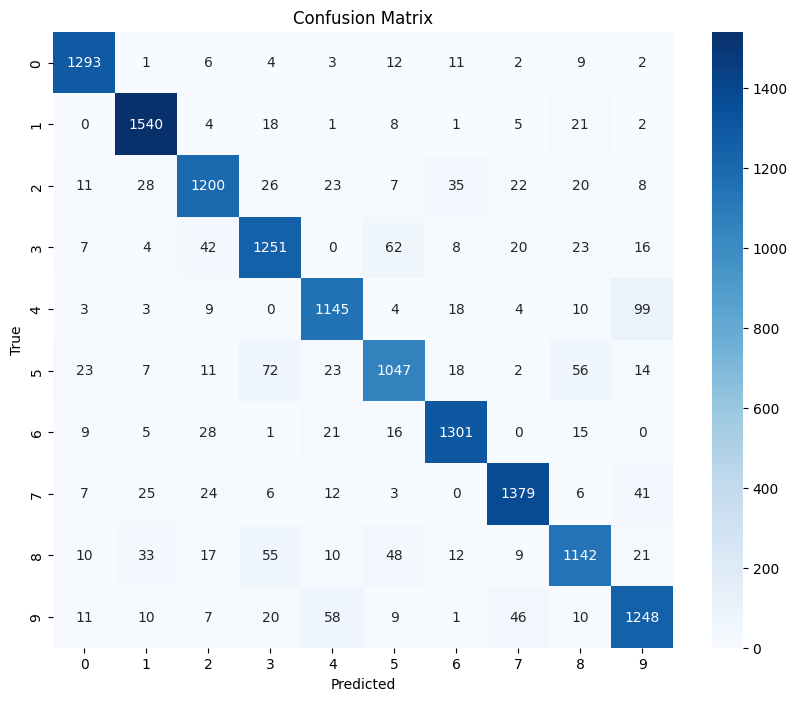

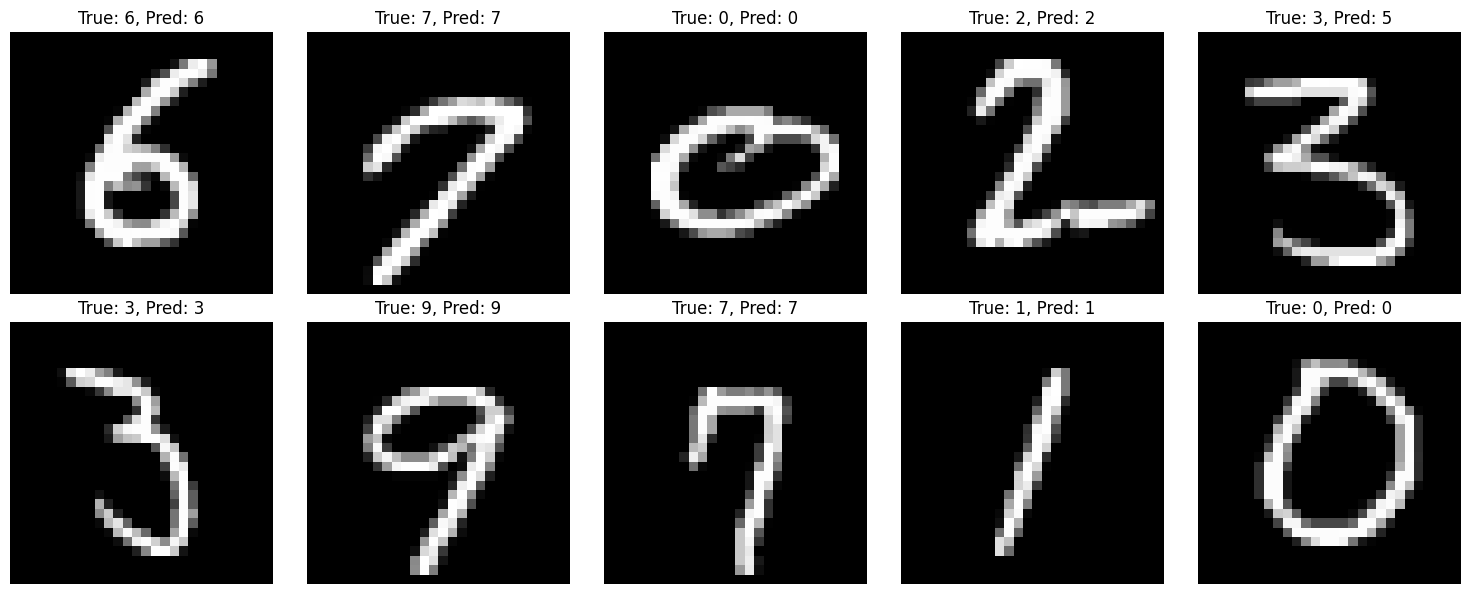


Weight distributions:


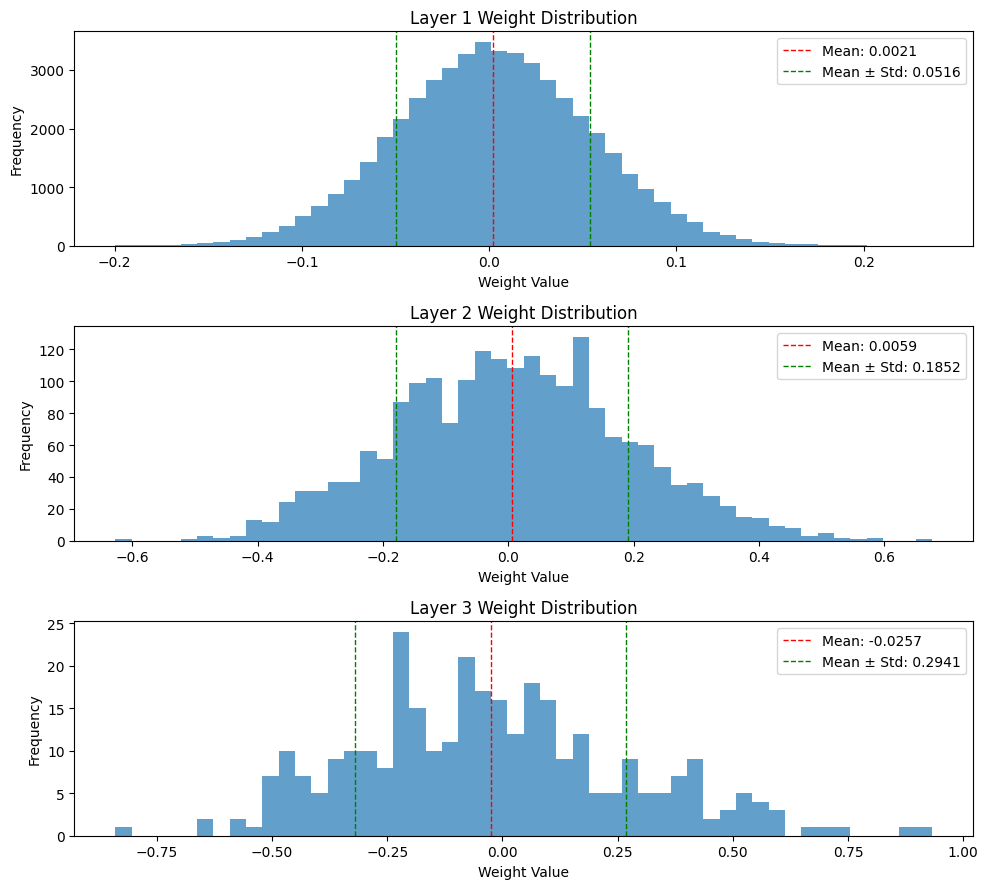


Gradient distributions:


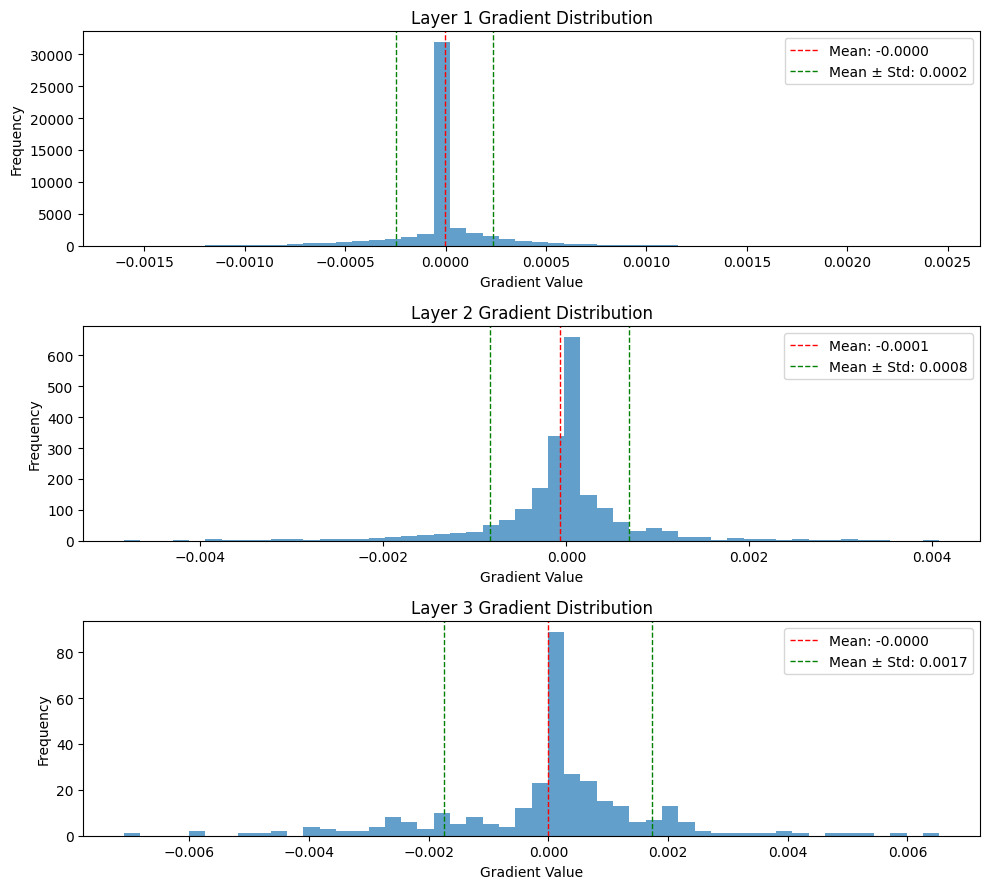


Training model with learning rate: 0.1
Epoch 1/20 [5.0%] - train_loss: 1.2799 - val_loss: 0.6183
Epoch 2/20 [10.0%] - train_loss: 0.4851 - val_loss: 0.4032
Epoch 3/20 [15.0%] - train_loss: 0.3708 - val_loss: 0.3434
Epoch 4/20 [20.0%] - train_loss: 0.3248 - val_loss: 0.3113
Epoch 5/20 [25.0%] - train_loss: 0.2964 - val_loss: 0.2892
Epoch 6/20 [30.0%] - train_loss: 0.2759 - val_loss: 0.2725
Epoch 7/20 [35.0%] - train_loss: 0.2592 - val_loss: 0.2585
Epoch 8/20 [40.0%] - train_loss: 0.2445 - val_loss: 0.2474
Epoch 9/20 [45.0%] - train_loss: 0.2325 - val_loss: 0.2371
Epoch 10/20 [50.0%] - train_loss: 0.2216 - val_loss: 0.2286
Epoch 11/20 [55.0%] - train_loss: 0.2118 - val_loss: 0.2202
Epoch 12/20 [60.0%] - train_loss: 0.2030 - val_loss: 0.2139
Epoch 13/20 [65.0%] - train_loss: 0.1949 - val_loss: 0.2075
Epoch 14/20 [70.0%] - train_loss: 0.1873 - val_loss: 0.2016
Epoch 15/20 [75.0%] - train_loss: 0.1808 - val_loss: 0.1957
Epoch 16/20 [80.0%] - train_loss: 0.1744 - val_loss: 0.1913
Epoch 17/2

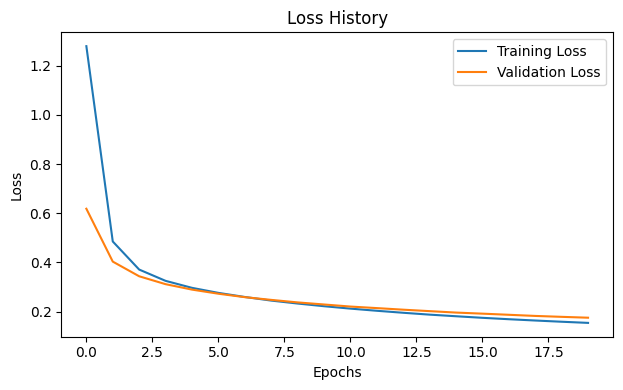


Evaluating model with learning rate 0.1...
Accuracy: 0.9495
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1343
           1       0.96      0.98      0.97      1600
           2       0.97      0.93      0.95      1380
           3       0.93      0.94      0.93      1433
           4       0.93      0.95      0.94      1295
           5       0.93      0.93      0.93      1273
           6       0.96      0.97      0.96      1396
           7       0.95      0.96      0.96      1503
           8       0.94      0.92      0.93      1357
           9       0.95      0.93      0.94      1420

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



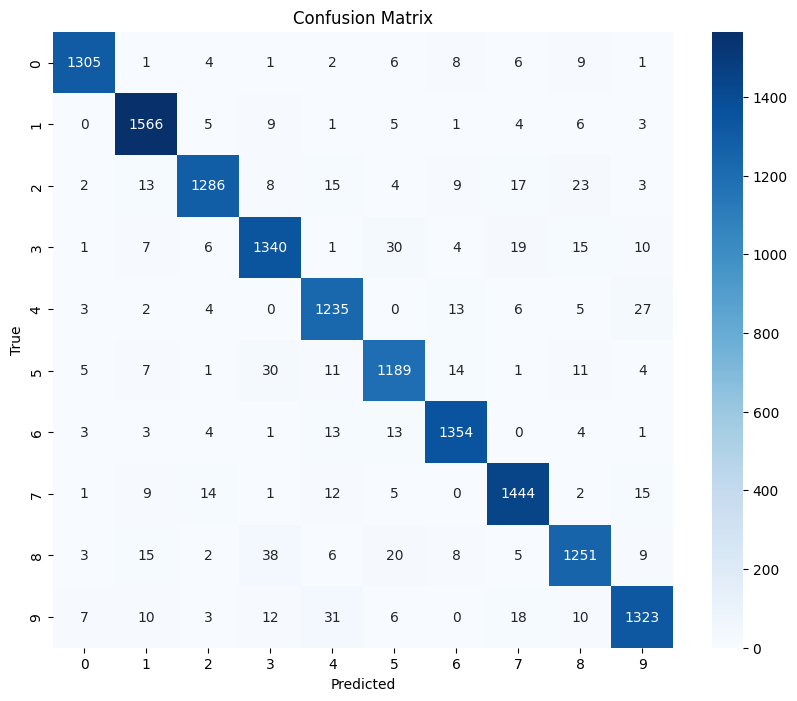

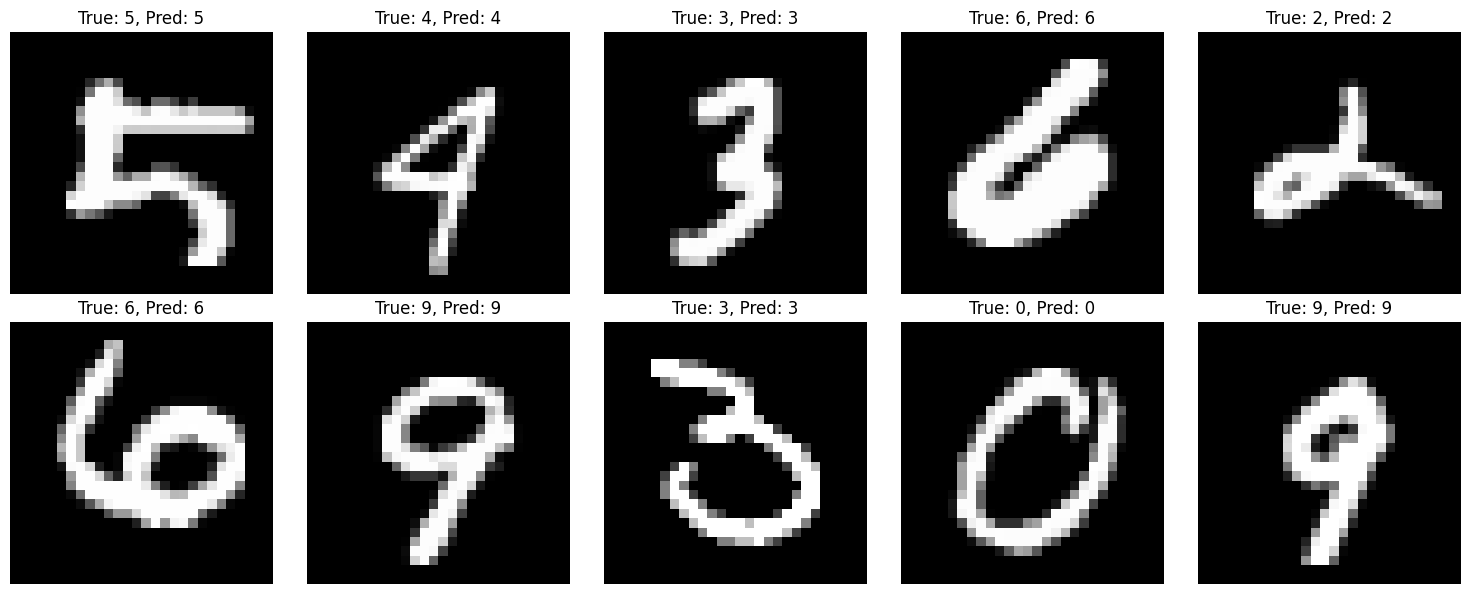


Weight distributions:


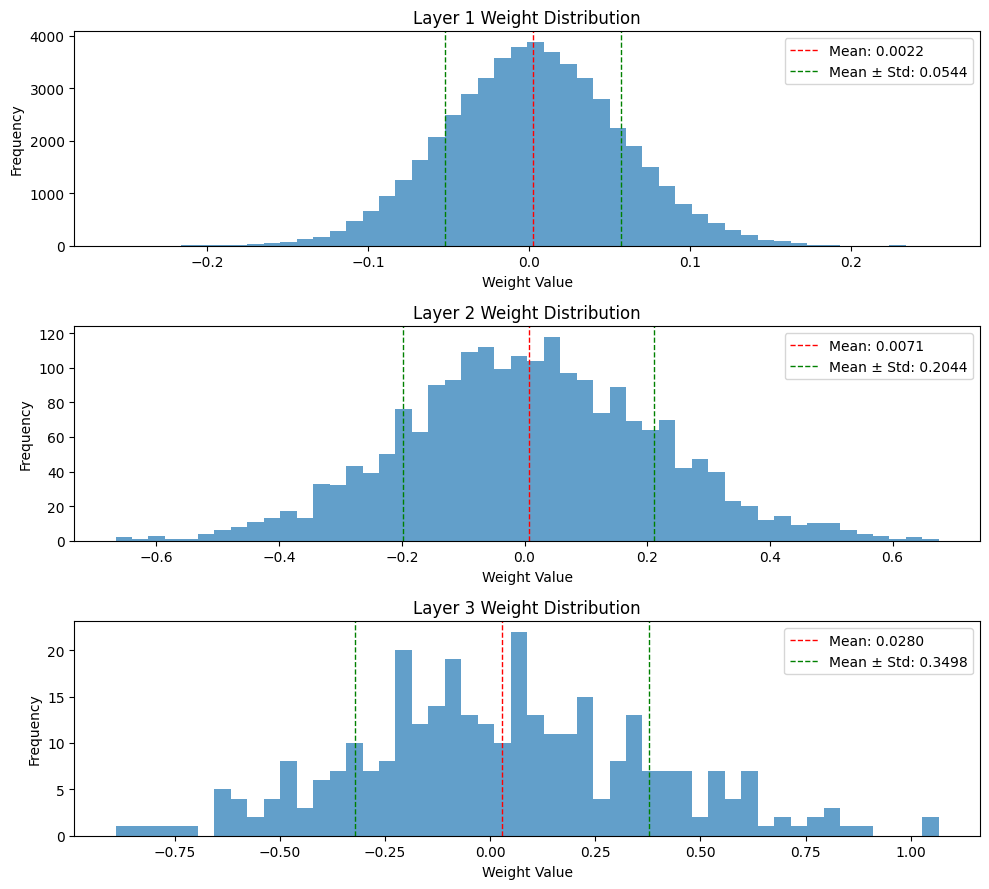


Gradient distributions:


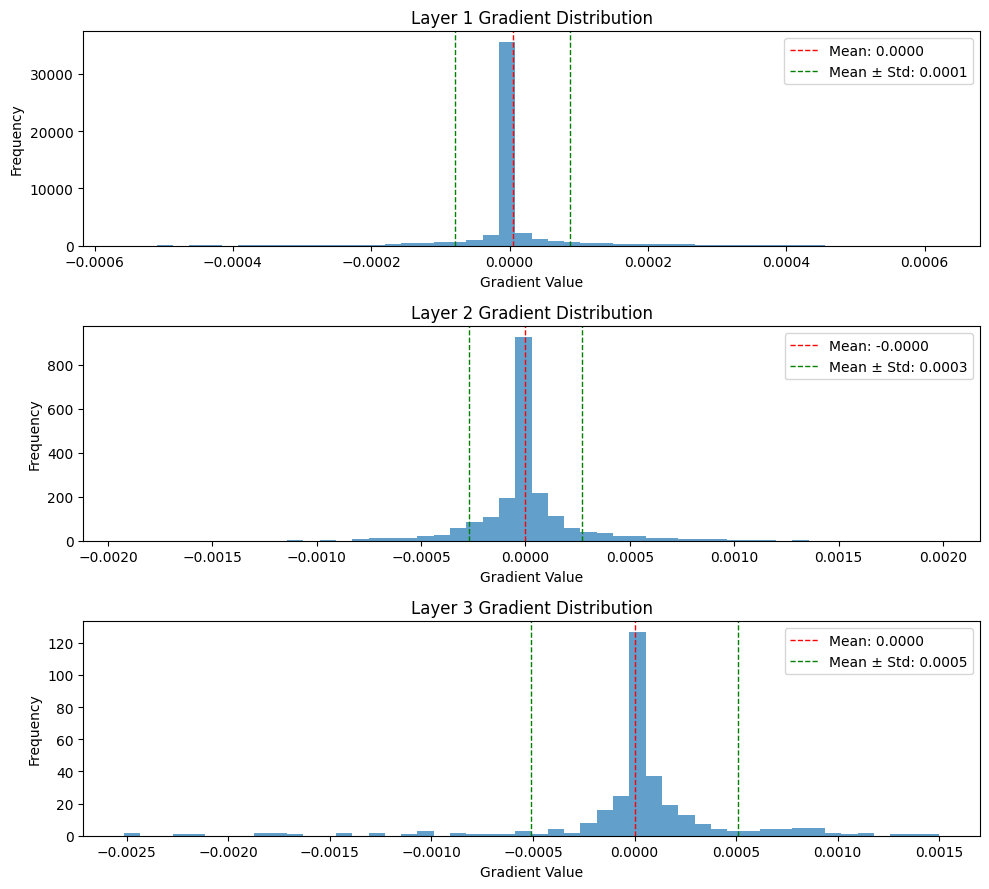


Learning Rate Comparison Results:
   learning_rate  accuracy  final_train_loss  final_val_loss  training_time
0          0.001  0.507857          1.674785        1.654213      34.942863
1          0.010  0.896143          0.381024        0.381921      34.026578
2          0.100  0.949500          0.153756        0.174834      31.878389


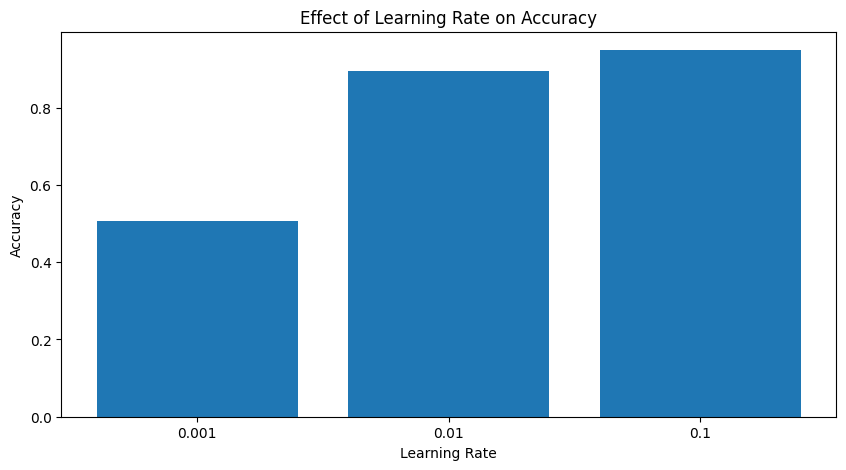

In [10]:
lr_results = []

for lr in learning_rates:
    print(f"\nTraining model with learning rate: {lr}")
    
    
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=base_architecture['activations'],
        loss=base_architecture['loss']
    )
    
    
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=lr,
        verbose=1
    )
    training_time = time.time() - start_time
    
    
    plot_history(history)
    
    
    print(f"\nEvaluating model with learning rate {lr}...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    
    lr_results.append({
        'learning_rate': lr,
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display learning rate results
print("\nLearning Rate Comparison Results:")
lr_df = pd.DataFrame(lr_results)
print(lr_df[['learning_rate', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

plt.figure(figsize=(10, 5))
plt.bar([str(r['learning_rate']) for r in lr_results], [r['accuracy'] for r in lr_results])
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Effect of Learning Rate on Accuracy')
plt.show()

## Experiment 4 : Effect of Weight Initialization

In [11]:
weight_inits = [
    {
        'name': 'Zero',
        'method': 'zero',
        'params': {}
    },
    {
        'name': 'Uniform',
        'method': 'uniform',
        'params': {'low': -0.1, 'high': 0.1, 'seed': 42}
    },
    {
        'name': 'Normal',
        'method': 'normal',
        'params': {'mean': 0, 'var': 0.1, 'seed': 42}
    },
    {
        'name': 'Xavier',
        'method': 'xavier',
        'params': {'seed': 42}
    },
    {
        'name': 'He',
        'method': 'he',
        'params': {'seed': 42}
    }
]

base_architecture = {
    'layers': [64, 32, 10],
    'activations': ['relu', 'relu', 'softmax'],
    'loss': 'categorical_cross_entropy'
}

params = {
    'epochs': 15,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with weight initialization: Zero
Epoch 1/15 [6.7%] - train_loss: 2.3025 - val_loss: 2.3024
Epoch 2/15 [13.3%] - train_loss: 2.3024 - val_loss: 2.3023
Epoch 3/15 [20.0%] - train_loss: 2.3023 - val_loss: 2.3021
Epoch 4/15 [26.7%] - train_loss: 2.3022 - val_loss: 2.3020
Epoch 5/15 [33.3%] - train_loss: 2.3021 - val_loss: 2.3019
Epoch 6/15 [40.0%] - train_loss: 2.3020 - val_loss: 2.3018
Epoch 7/15 [46.7%] - train_loss: 2.3019 - val_loss: 2.3017
Epoch 8/15 [53.3%] - train_loss: 2.3018 - val_loss: 2.3017
Epoch 9/15 [60.0%] - train_loss: 2.3018 - val_loss: 2.3016
Epoch 10/15 [66.7%] - train_loss: 2.3017 - val_loss: 2.3015
Epoch 11/15 [73.3%] - train_loss: 2.3017 - val_loss: 2.3015
Epoch 12/15 [80.0%] - train_loss: 2.3016 - val_loss: 2.3014
Epoch 13/15 [86.7%] - train_loss: 2.3016 - val_loss: 2.3014
Epoch 14/15 [93.3%] - train_loss: 2.3015 - val_loss: 2.3013
Epoch 15/15 [100.0%] - train_loss: 2.3015 - val_loss: 2.3013


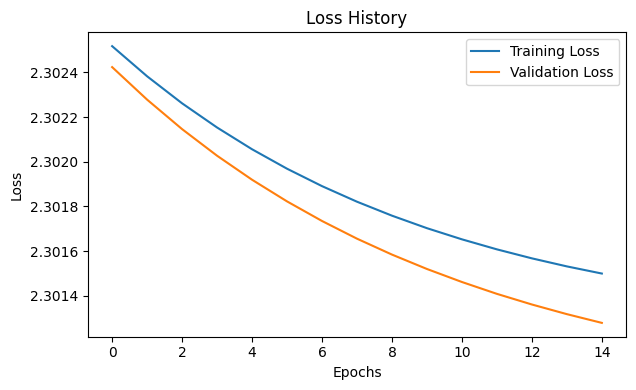


Evaluating model with Zero initialization...
Accuracy: 0.1143
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1343
           1       0.11      1.00      0.21      1600
           2       0.00      0.00      0.00      1380
           3       0.00      0.00      0.00      1433
           4       0.00      0.00      0.00      1295
           5       0.00      0.00      0.00      1273
           6       0.00      0.00      0.00      1396
           7       0.00      0.00      0.00      1503
           8       0.00      0.00      0.00      1357
           9       0.00      0.00      0.00      1420

    accuracy                           0.11     14000
   macro avg       0.01      0.10      0.02     14000
weighted avg       0.01      0.11      0.02     14000



c:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP Omen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

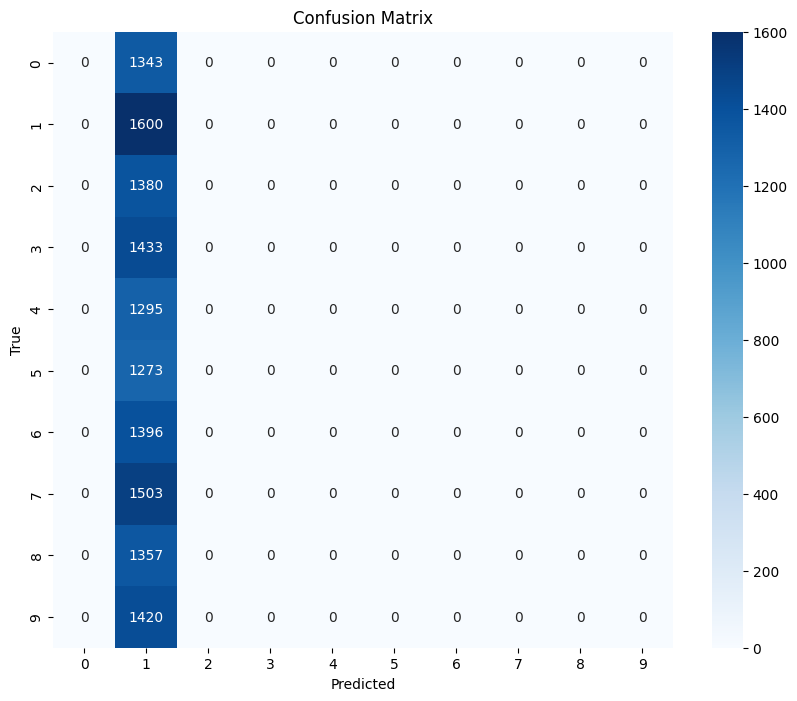

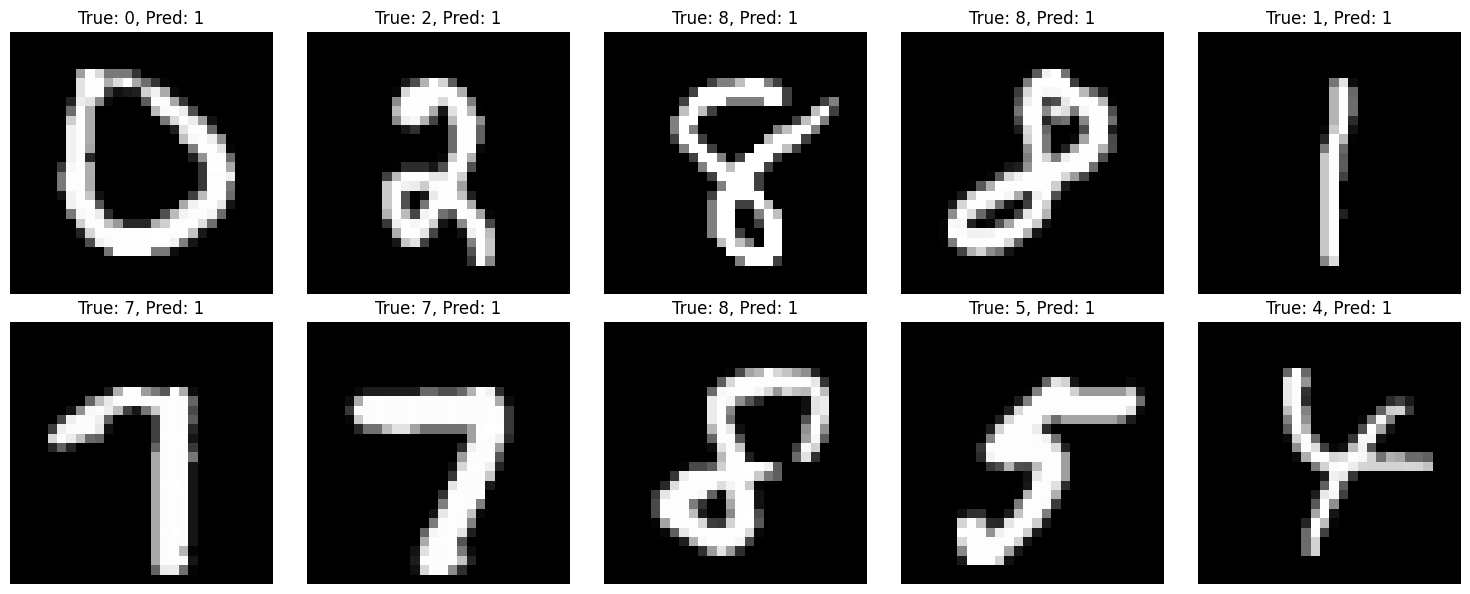


Weight distributions:


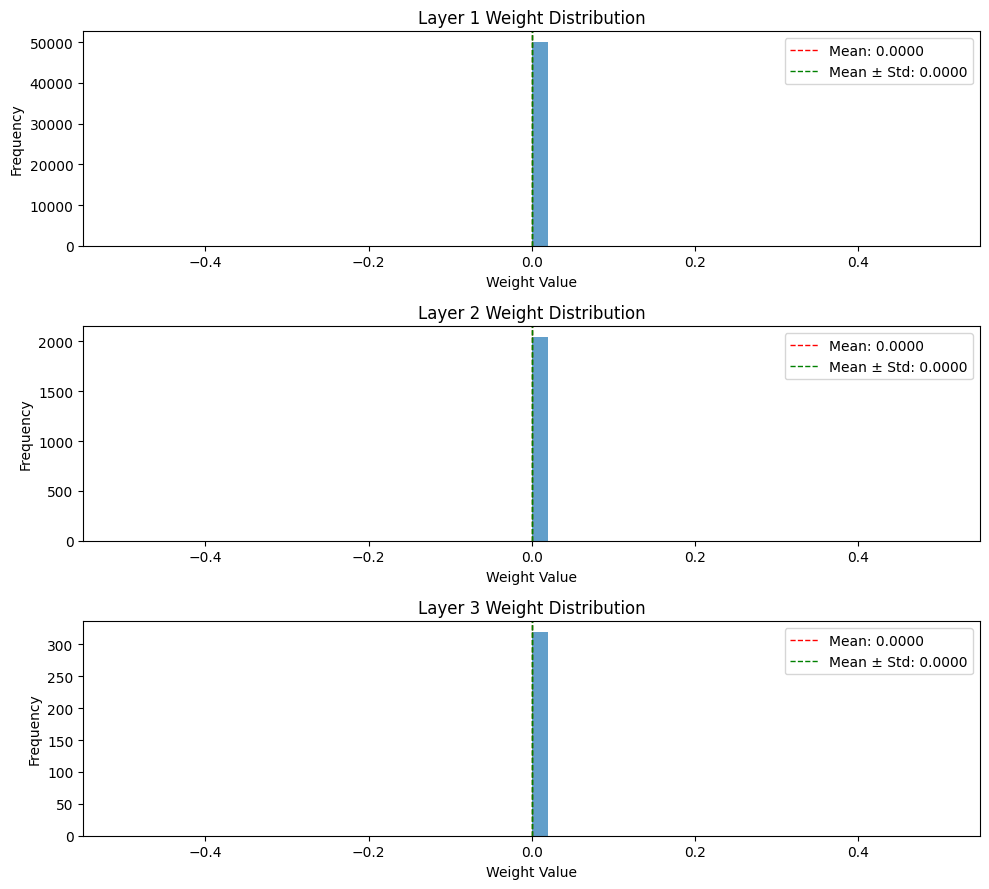


Training model with weight initialization: Uniform
Epoch 1/15 [6.7%] - train_loss: 2.3000 - val_loss: 2.2960
Epoch 2/15 [13.3%] - train_loss: 2.2911 - val_loss: 2.2869
Epoch 3/15 [20.0%] - train_loss: 2.2814 - val_loss: 2.2764
Epoch 4/15 [26.7%] - train_loss: 2.2699 - val_loss: 2.2638
Epoch 5/15 [33.3%] - train_loss: 2.2556 - val_loss: 2.2477
Epoch 6/15 [40.0%] - train_loss: 2.2368 - val_loss: 2.2262
Epoch 7/15 [46.7%] - train_loss: 2.2116 - val_loss: 2.1970
Epoch 8/15 [53.3%] - train_loss: 2.1770 - val_loss: 2.1572
Epoch 9/15 [60.0%] - train_loss: 2.1298 - val_loss: 2.1025
Epoch 10/15 [66.7%] - train_loss: 2.0655 - val_loss: 2.0287
Epoch 11/15 [73.3%] - train_loss: 1.9804 - val_loss: 1.9331
Epoch 12/15 [80.0%] - train_loss: 1.8742 - val_loss: 1.8173
Epoch 13/15 [86.7%] - train_loss: 1.7512 - val_loss: 1.6883
Epoch 14/15 [93.3%] - train_loss: 1.6202 - val_loss: 1.5561
Epoch 15/15 [100.0%] - train_loss: 1.4914 - val_loss: 1.4303


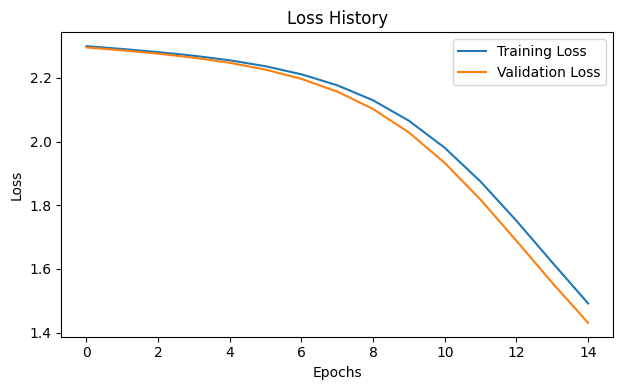


Evaluating model with Uniform initialization...
Accuracy: 0.6374
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.95      0.74      1343
           1       0.70      0.97      0.81      1600
           2       0.79      0.59      0.67      1380
           3       0.50      0.76      0.61      1433
           4       0.62      0.65      0.64      1295
           5       0.98      0.04      0.08      1273
           6       0.77      0.52      0.62      1396
           7       0.71      0.79      0.75      1503
           8       0.50      0.40      0.45      1357
           9       0.61      0.58      0.60      1420

    accuracy                           0.64     14000
   macro avg       0.68      0.63      0.60     14000
weighted avg       0.68      0.64      0.60     14000



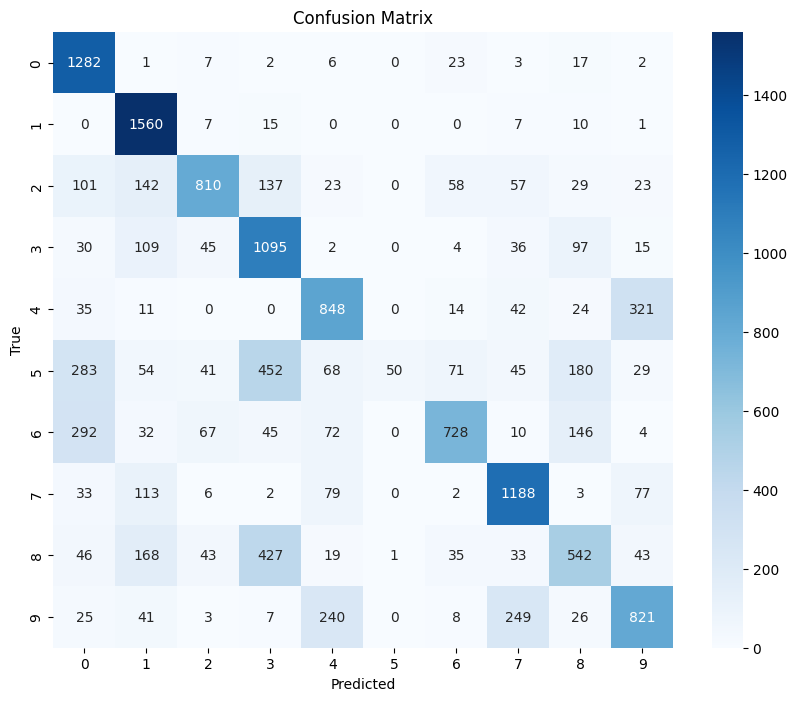

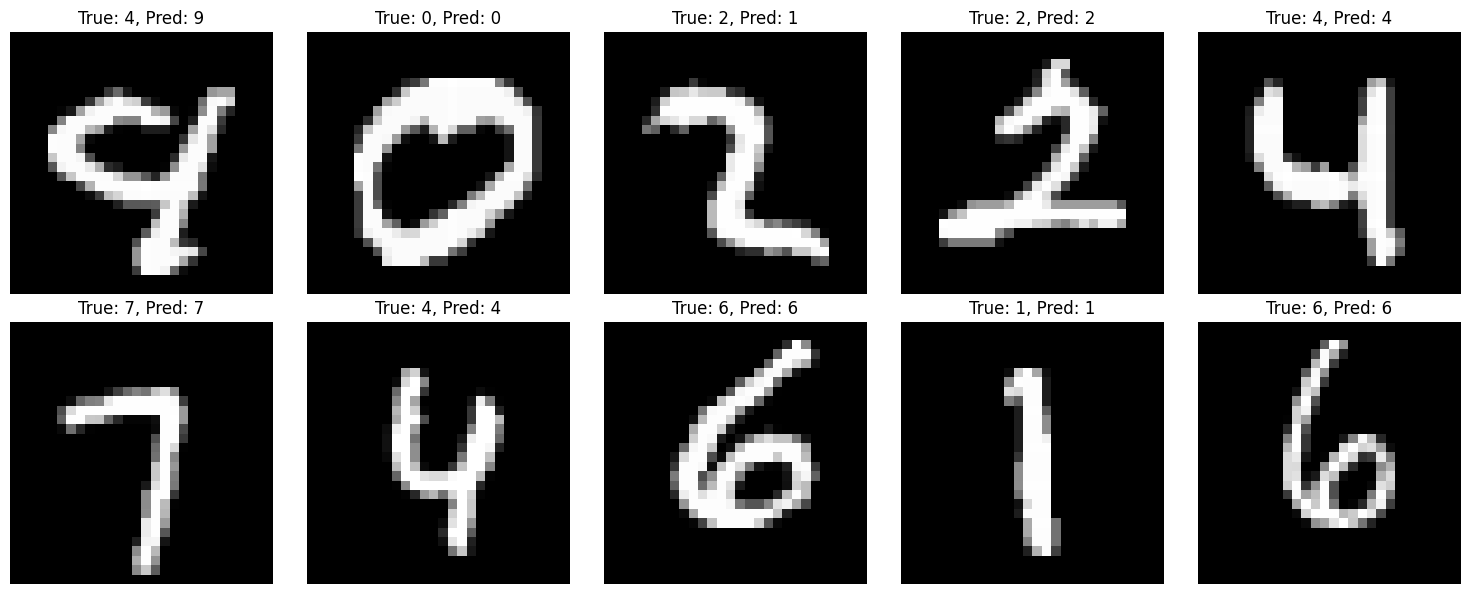


Weight distributions:


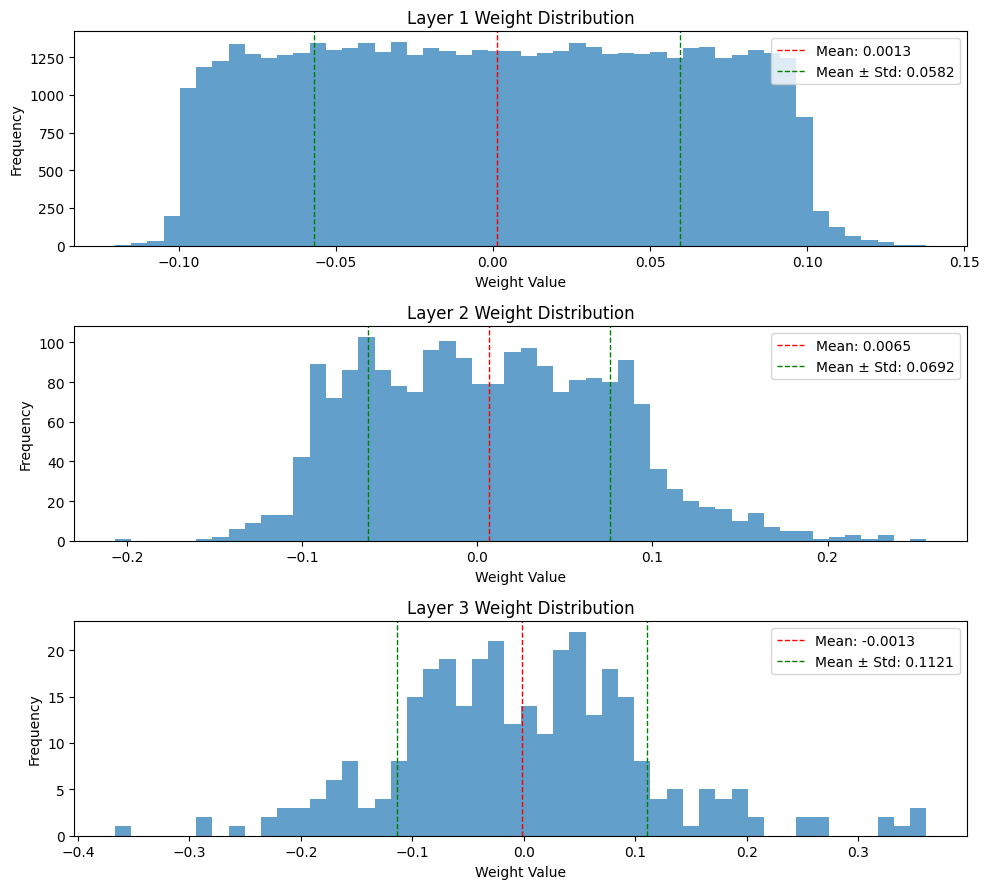


Training model with weight initialization: Normal
Epoch 1/15 [6.7%] - train_loss: 3.9263 - val_loss: 2.3379
Epoch 2/15 [13.3%] - train_loss: 1.9369 - val_loss: 1.6458
Epoch 3/15 [20.0%] - train_loss: 1.5031 - val_loss: 1.3765
Epoch 4/15 [26.7%] - train_loss: 1.3003 - val_loss: 1.2233
Epoch 5/15 [33.3%] - train_loss: 1.1744 - val_loss: 1.1190
Epoch 6/15 [40.0%] - train_loss: 1.0841 - val_loss: 1.0392
Epoch 7/15 [46.7%] - train_loss: 1.0145 - val_loss: 0.9768
Epoch 8/15 [53.3%] - train_loss: 0.9582 - val_loss: 0.9262
Epoch 9/15 [60.0%] - train_loss: 0.9114 - val_loss: 0.8820
Epoch 10/15 [66.7%] - train_loss: 0.8716 - val_loss: 0.8444
Epoch 11/15 [73.3%] - train_loss: 0.8374 - val_loss: 0.8118
Epoch 12/15 [80.0%] - train_loss: 0.8075 - val_loss: 0.7837
Epoch 13/15 [86.7%] - train_loss: 0.7810 - val_loss: 0.7590
Epoch 14/15 [93.3%] - train_loss: 0.7575 - val_loss: 0.7365
Epoch 15/15 [100.0%] - train_loss: 0.7365 - val_loss: 0.7156


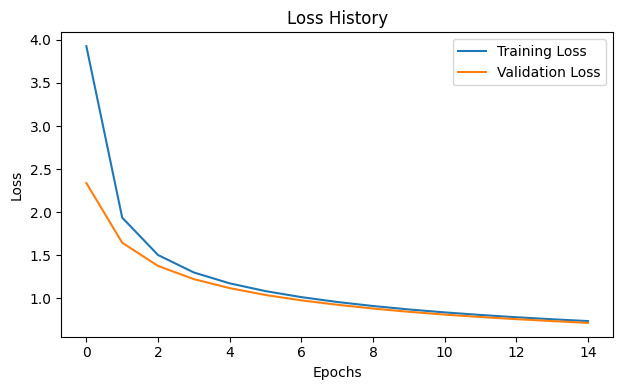


Evaluating model with Normal initialization...
Accuracy: 0.7761
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1343
           1       0.89      0.94      0.91      1600
           2       0.76      0.74      0.75      1380
           3       0.75      0.76      0.75      1433
           4       0.73      0.73      0.73      1295
           5       0.70      0.65      0.68      1273
           6       0.82      0.83      0.82      1396
           7       0.83      0.82      0.83      1503
           8       0.65      0.65      0.65      1357
           9       0.72      0.72      0.72      1420

    accuracy                           0.78     14000
   macro avg       0.77      0.77      0.77     14000
weighted avg       0.77      0.78      0.78     14000



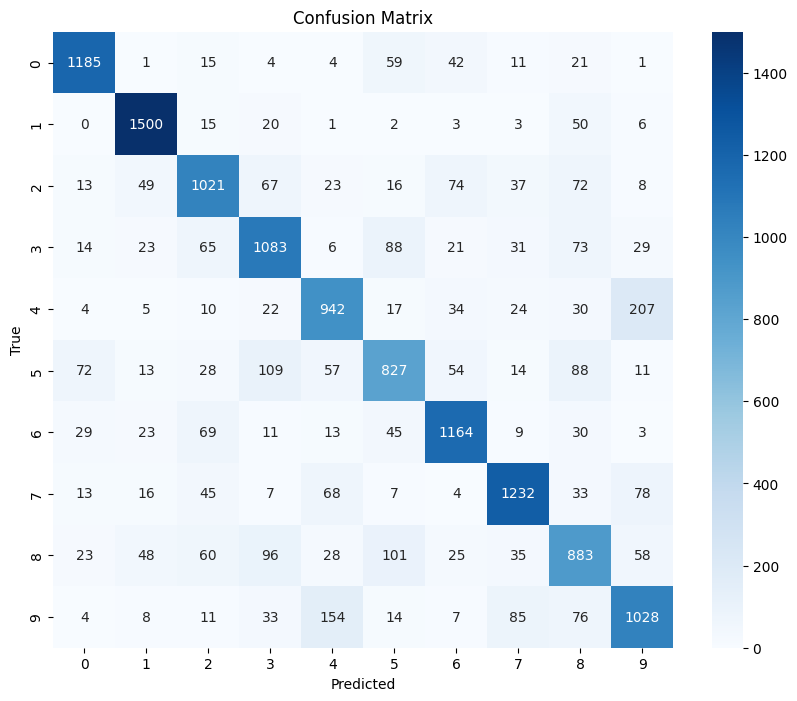

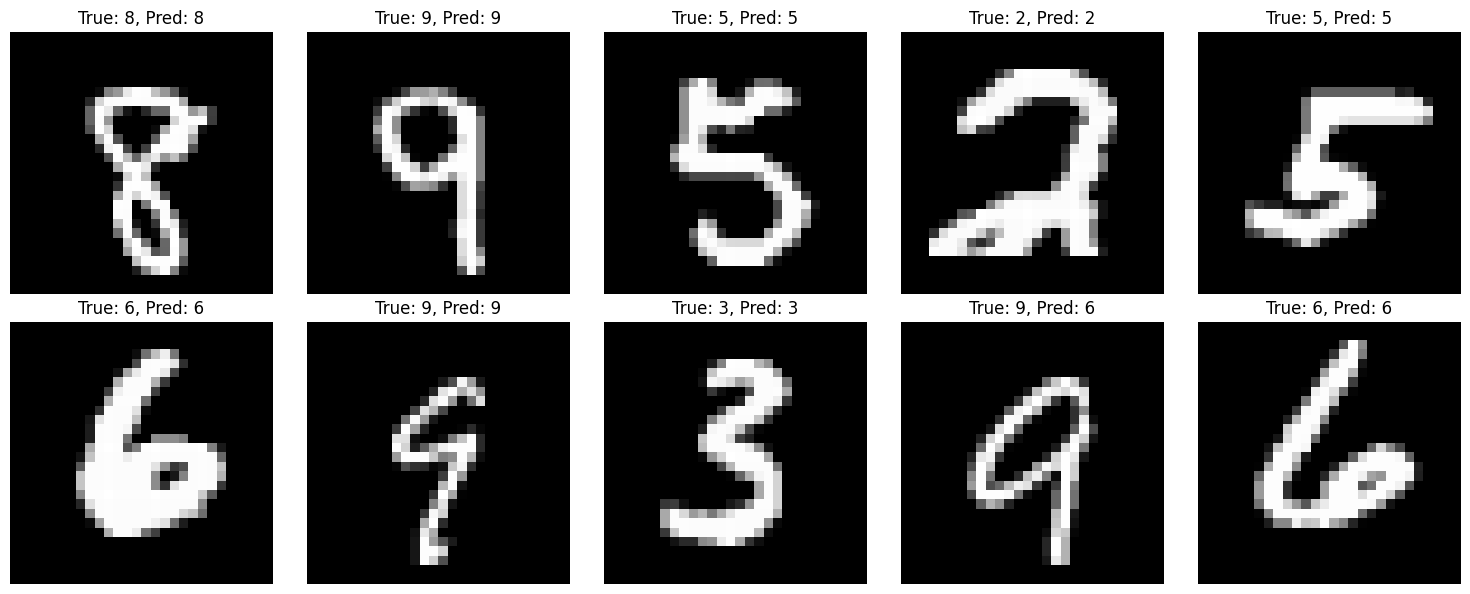


Weight distributions:


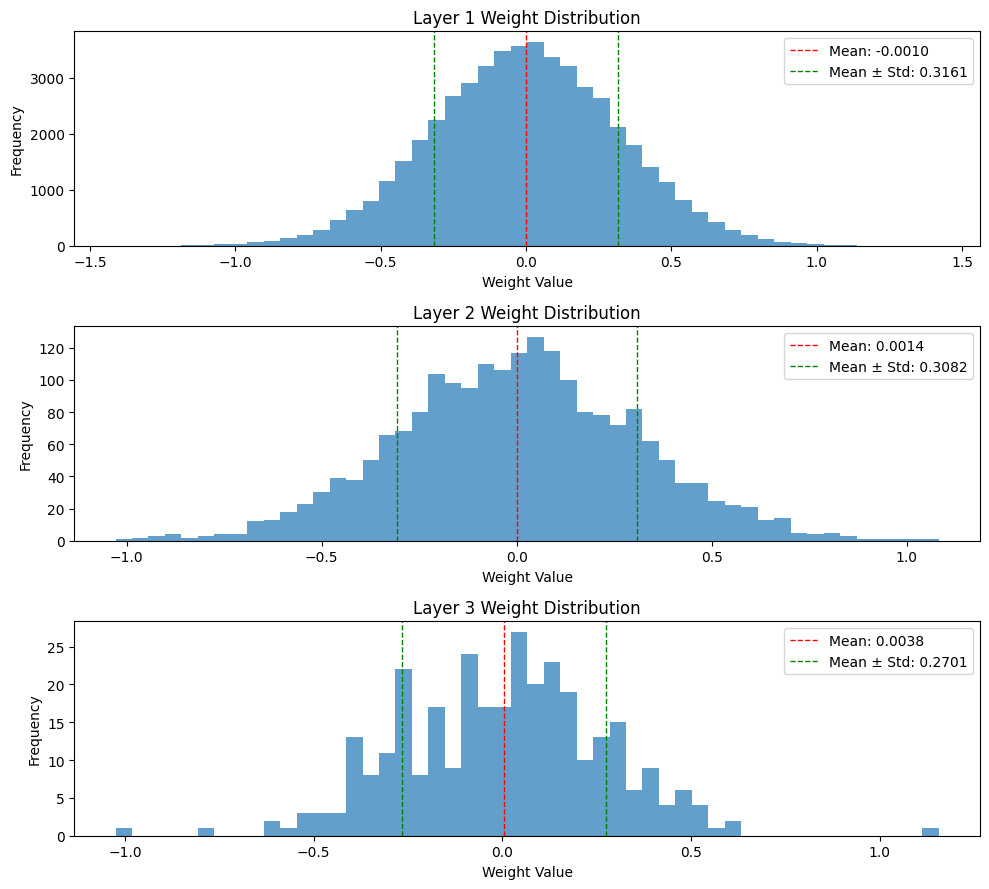


Training model with weight initialization: Xavier
Epoch 1/15 [6.7%] - train_loss: 2.1967 - val_loss: 2.0702
Epoch 2/15 [13.3%] - train_loss: 1.9346 - val_loss: 1.8000
Epoch 3/15 [20.0%] - train_loss: 1.6618 - val_loss: 1.5317
Epoch 4/15 [26.7%] - train_loss: 1.4085 - val_loss: 1.2934
Epoch 5/15 [33.3%] - train_loss: 1.1935 - val_loss: 1.0996
Epoch 6/15 [40.0%] - train_loss: 1.0249 - val_loss: 0.9525
Epoch 7/15 [46.7%] - train_loss: 0.8988 - val_loss: 0.8435
Epoch 8/15 [53.3%] - train_loss: 0.8043 - val_loss: 0.7615
Epoch 9/15 [60.0%] - train_loss: 0.7320 - val_loss: 0.6975
Epoch 10/15 [66.7%] - train_loss: 0.6752 - val_loss: 0.6470
Epoch 11/15 [73.3%] - train_loss: 0.6297 - val_loss: 0.6063
Epoch 12/15 [80.0%] - train_loss: 0.5926 - val_loss: 0.5731
Epoch 13/15 [86.7%] - train_loss: 0.5619 - val_loss: 0.5453
Epoch 14/15 [93.3%] - train_loss: 0.5360 - val_loss: 0.5221
Epoch 15/15 [100.0%] - train_loss: 0.5141 - val_loss: 0.5020


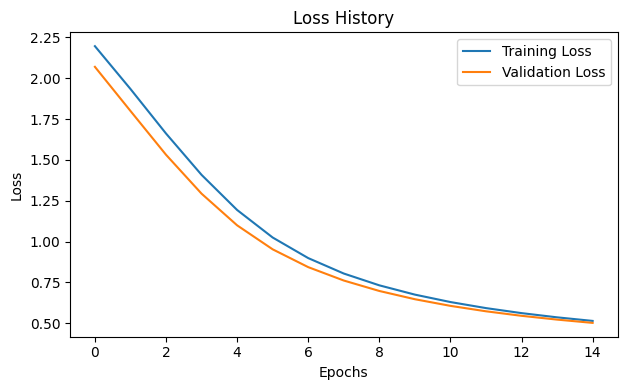


Evaluating model with Xavier initialization...
Accuracy: 0.8703
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1343
           1       0.90      0.96      0.93      1600
           2       0.89      0.84      0.87      1380
           3       0.83      0.83      0.83      1433
           4       0.87      0.88      0.88      1295
           5       0.85      0.76      0.80      1273
           6       0.89      0.92      0.91      1396
           7       0.89      0.90      0.90      1503
           8       0.81      0.81      0.81      1357
           9       0.83      0.84      0.83      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



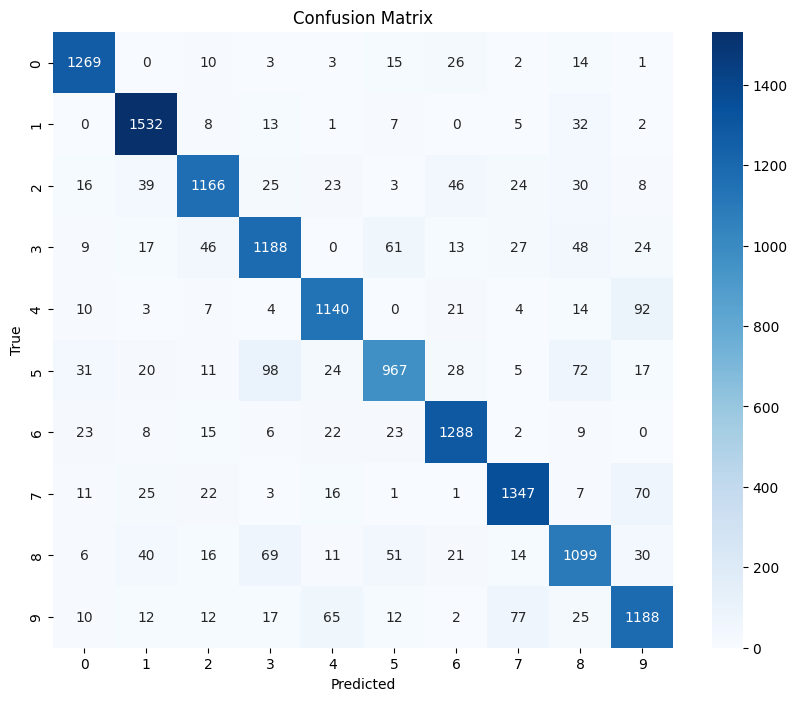

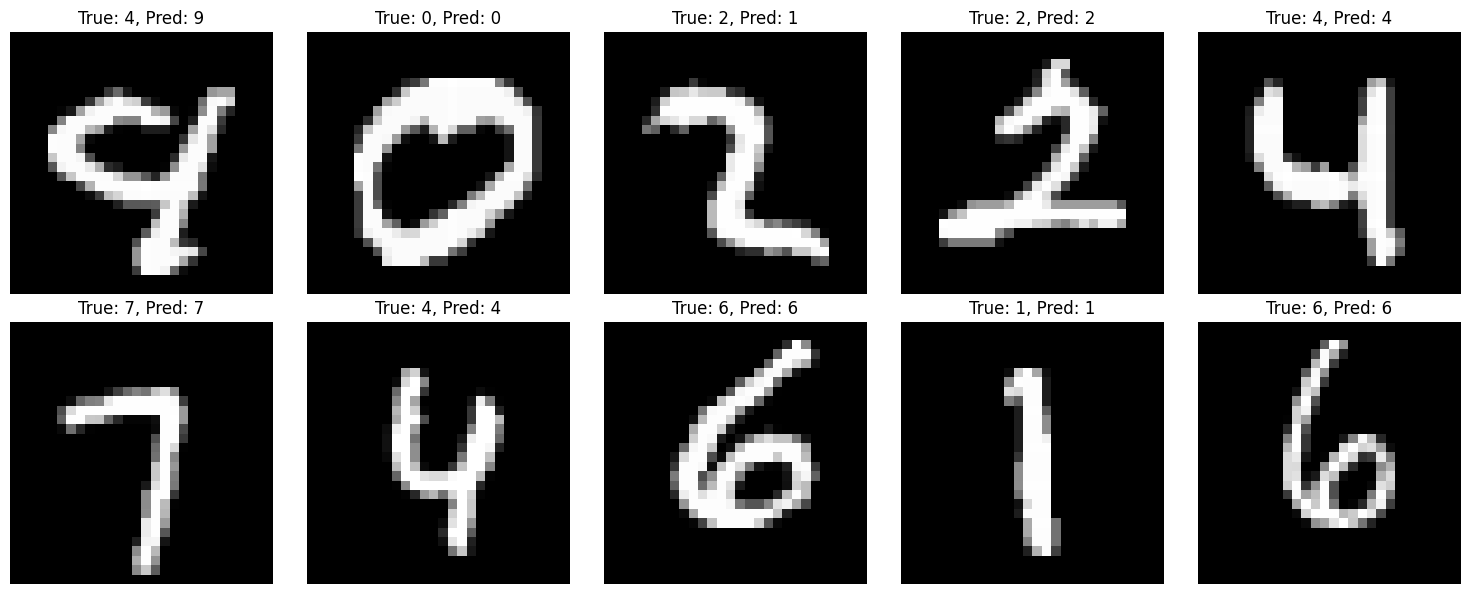


Weight distributions:


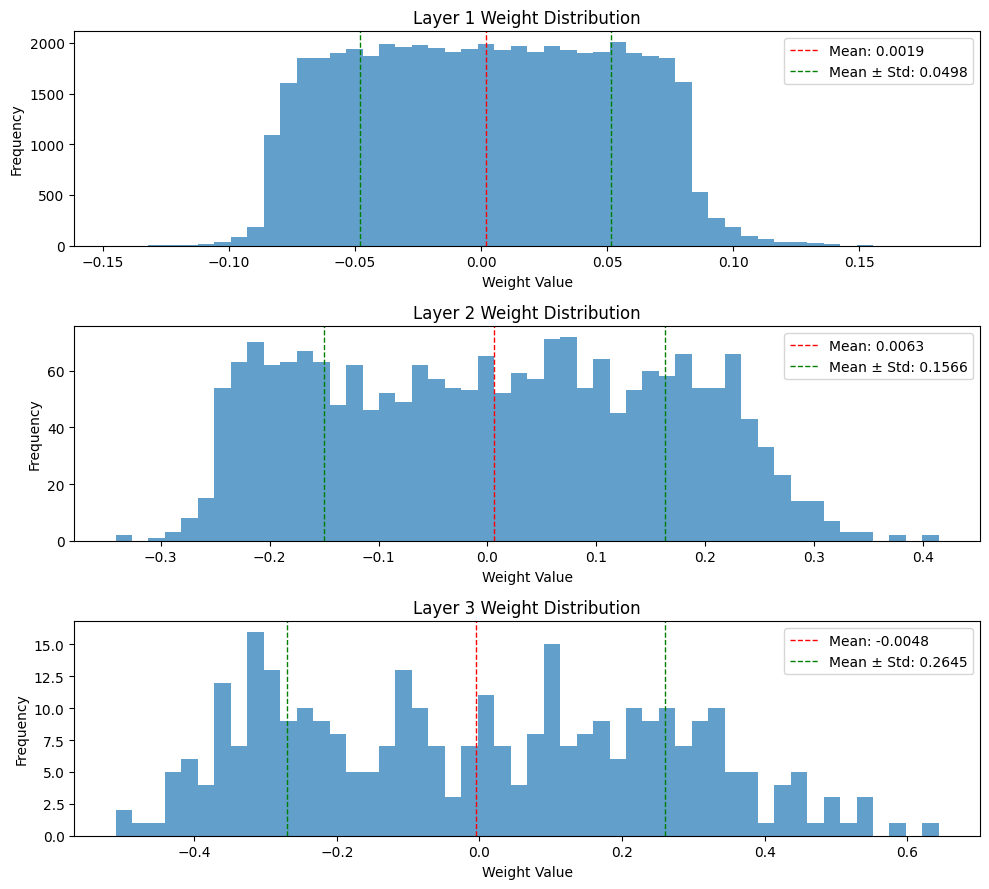


Training model with weight initialization: He
Epoch 1/15 [6.7%] - train_loss: 2.0968 - val_loss: 1.8448
Epoch 2/15 [13.3%] - train_loss: 1.6291 - val_loss: 1.4279
Epoch 3/15 [20.0%] - train_loss: 1.2717 - val_loss: 1.1299
Epoch 4/15 [26.7%] - train_loss: 1.0333 - val_loss: 0.9425
Epoch 5/15 [33.3%] - train_loss: 0.8835 - val_loss: 0.8221
Epoch 6/15 [40.0%] - train_loss: 0.7836 - val_loss: 0.7385
Epoch 7/15 [46.7%] - train_loss: 0.7121 - val_loss: 0.6770
Epoch 8/15 [53.3%] - train_loss: 0.6577 - val_loss: 0.6293
Epoch 9/15 [60.0%] - train_loss: 0.6145 - val_loss: 0.5906
Epoch 10/15 [66.7%] - train_loss: 0.5791 - val_loss: 0.5586
Epoch 11/15 [73.3%] - train_loss: 0.5494 - val_loss: 0.5315
Epoch 12/15 [80.0%] - train_loss: 0.5241 - val_loss: 0.5086
Epoch 13/15 [86.7%] - train_loss: 0.5021 - val_loss: 0.4888
Epoch 14/15 [93.3%] - train_loss: 0.4829 - val_loss: 0.4714
Epoch 15/15 [100.0%] - train_loss: 0.4661 - val_loss: 0.4556


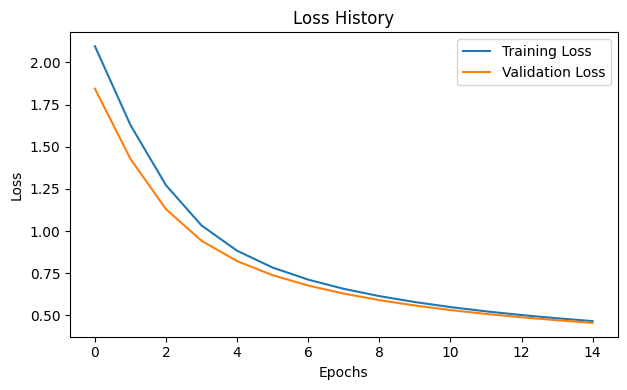


Evaluating model with He initialization...
Accuracy: 0.8779
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1343
           1       0.91      0.97      0.94      1600
           2       0.89      0.84      0.86      1380
           3       0.84      0.85      0.84      1433
           4       0.86      0.90      0.88      1295
           5       0.85      0.80      0.82      1273
           6       0.89      0.92      0.91      1396
           7       0.91      0.90      0.91      1503
           8       0.82      0.79      0.80      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



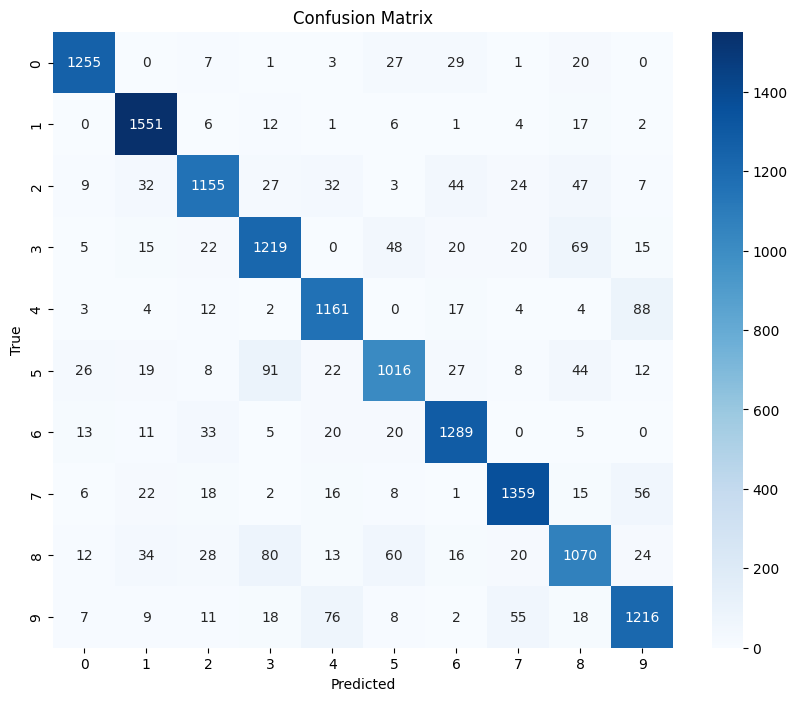

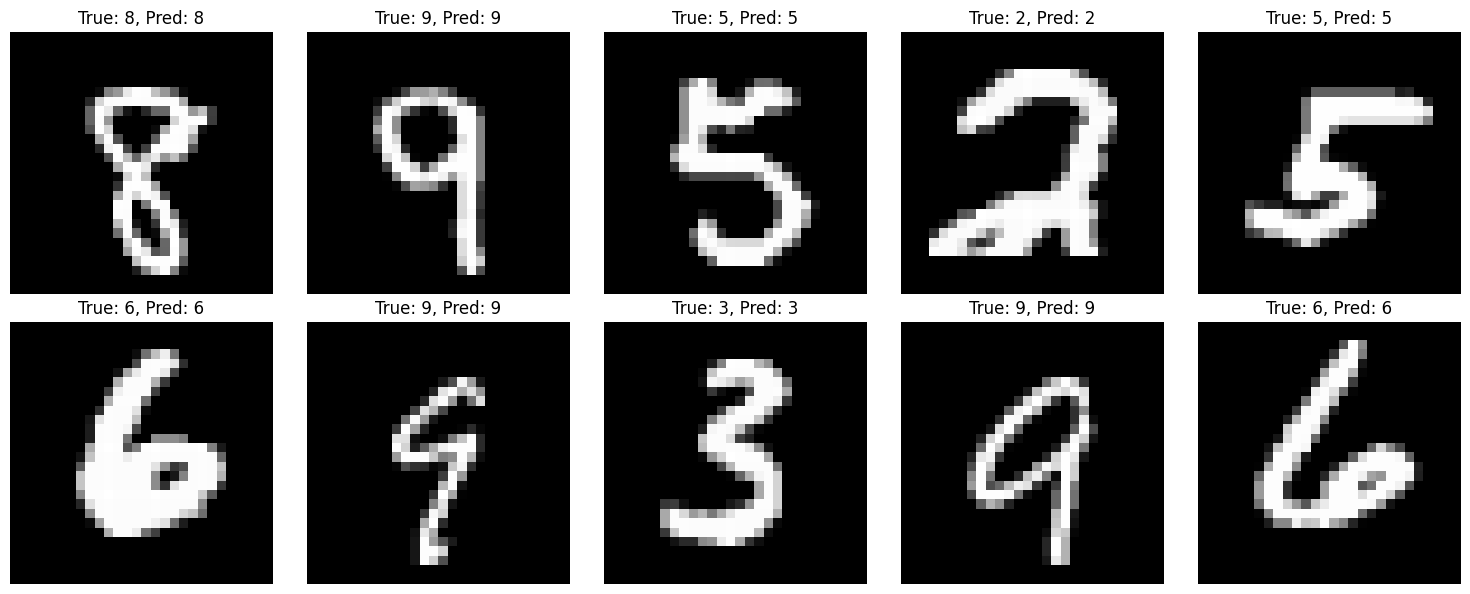


Weight distributions:


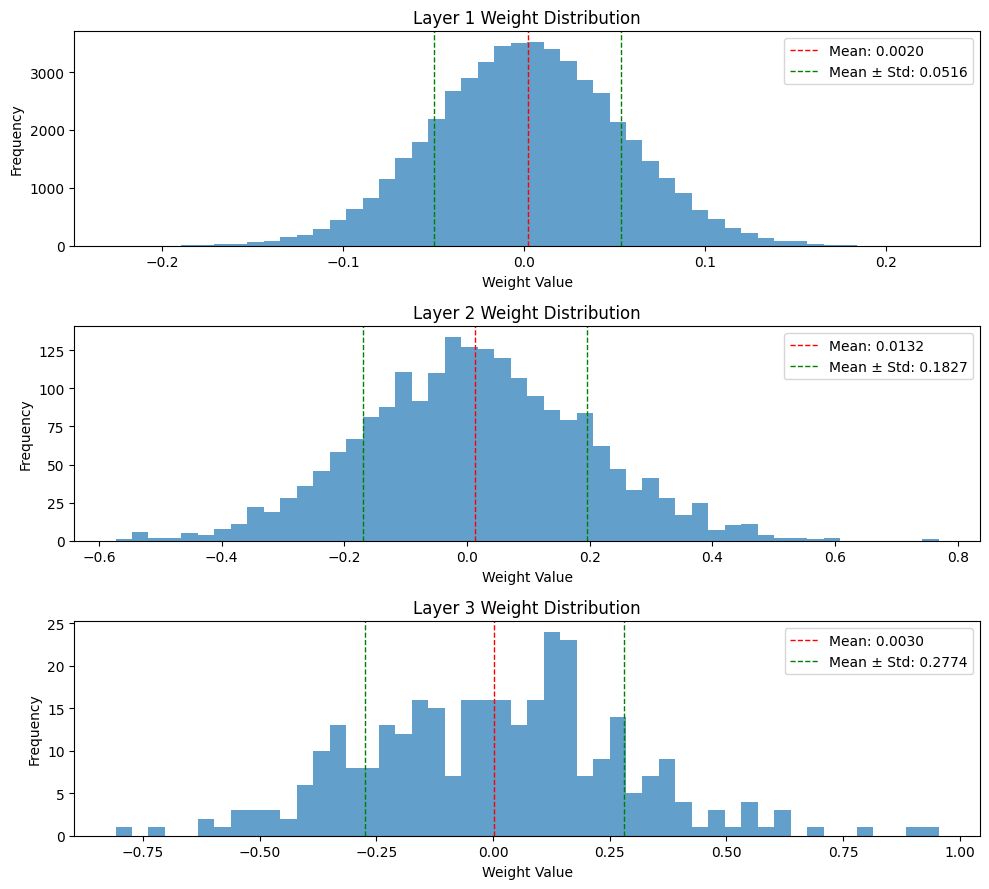


Weight Initialization Comparison Results:
  initialization  accuracy  final_train_loss  final_val_loss  training_time
0           Zero  0.114286          2.301500        2.301279      24.163747
1        Uniform  0.637429          1.491394        1.430305      26.691214
2         Normal  0.776071          0.736490        0.715627      29.073524
3         Xavier  0.870286          0.514117        0.502029      26.750420
4             He  0.877929          0.466123        0.455599      26.901444


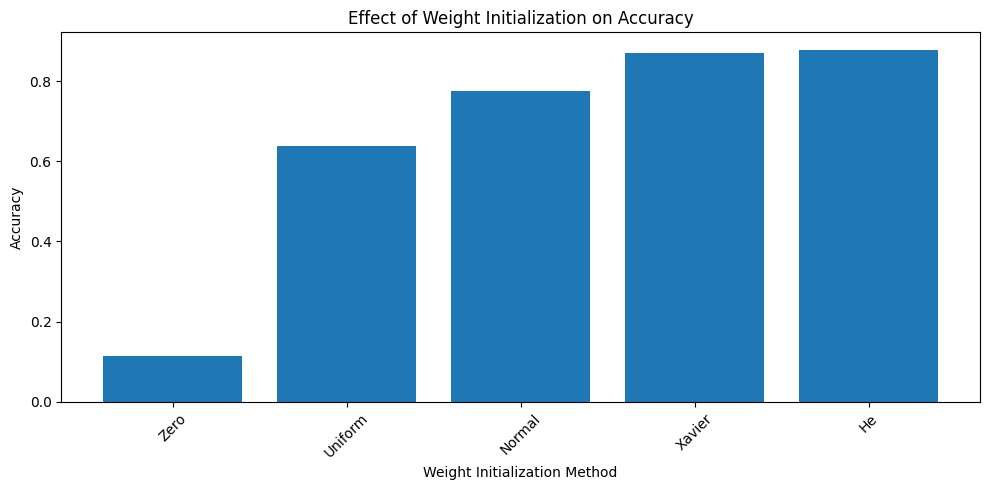

In [12]:
init_results = []

for init in weight_inits:
    print(f"\nTraining model with weight initialization: {init['name']}")
    
    # Create the model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=base_architecture['activations'],
        loss=base_architecture['loss'],
        weight_init=init['method'],
        weight_init_params=init['params']
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)
    
    # Evaluate model
    print(f"\nEvaluating model with {init['name']} initialization...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    # Plot weight distributions for initial and final weights
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    # Store results
    init_results.append({
        'initialization': init['name'],
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display initialization results
print("\nWeight Initialization Comparison Results:")
init_df = pd.DataFrame(init_results)
print(init_df[['initialization', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

# Plot comparative results
plt.figure(figsize=(10, 5))
plt.bar([r['initialization'] for r in init_results], [r['accuracy'] for r in init_results])
plt.xlabel('Weight Initialization Method')
plt.ylabel('Accuracy')
plt.title('Effect of Weight Initialization on Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Experiment 5 : Comparison with sklearn MLP

## Bonus Experiment 1: Effect of Regularization (L1 and L2)

## Bonus Experiment 2: Additional Activation Functions